# CPU Performance Prediction with ML Pipeline
**Dataset:** 96 CPUs with 27 hardware specifications and strategically introduced missing values

## Step 1: Import Required Libraries

In [62]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

In [63]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [65]:
# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [66]:
# XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

In [67]:
# Metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)

In [68]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [69]:
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Pandas version: 2.3.3
NumPy version: 2.3.3
XGBoost version: 3.1.1
LightGBM version: 4.6.0


# Step 2: Load and Explore Dataset

## Step 2: Load Dataset with Missing Values

This dataset has been preprocessed to include strategic missing values (1% of data) for comprehensive preprocessing demonstrations.

In [70]:
# Load dataset with intentional missing values
df_original = pd.read_csv('cpu_performance_dataset_with_missing.csv')
print(f"Dataset loaded: {df_original.shape[0]} rows, {df_original.shape[1]} columns")
print(f"\nFirst few rows:")
df_original.head()

Dataset loaded: 96 rows, 27 columns

First few rows:


,Brand,Model,Type,Year,Cores,P_Cores,E_Cores,Threads,Base_Clock_GHz,Boost_Clock_GHz,...,PCIe_Gen,PCIe_Lanes,Max_Memory_GB,Memory_Channels,Memory_Type,Memory_Speed_MHz,Unlocked,Hyper_Threading,Release_Quarter,Memory_Bandwidth_GBps
0,Intel,Core i9-13980HX,Laptop,2023,24,8,16,32,2.2,5.6,...,5,20.0,128.0,2,DDR5-5600,5600,Yes,Yes,Q1-2023,89.6
1,Intel,Core i9-13950HX,Laptop,2023,24,8,16,32,2.2,5.5,...,5,20.0,128.0,2,DDR5-5600,5600,Yes,Yes,Q1-2023,89.6
2,Intel,Core i9-13900HX,Laptop,2023,24,8,16,32,2.2,5.4,...,5,20.0,128.0,2,DDR5-5600,5600,No,Yes,Q1-2023,89.6
3,Intel,Core i7-13850HX,Laptop,2023,20,6,14,28,2.1,5.3,...,5,20.0,128.0,2,DDR5-5600,5600,Partial,Yes,Q1-2023,89.6
4,Intel,Core i7-13700HX,Laptop,2023,16,8,8,24,2.1,5.0,...,5,20.0,NaN,2,DDR5-5600,5600,No,Yes,Q1-2023,89.6


## Step 3: Missing Value Detection and Analysis

Analyzing the distribution and patterns of missing data is crucial for selecting appropriate imputation strategies.

In [71]:
# Check for missing values
missing_info = df_original.isnull().sum()
missing_percent = (missing_info / len(df_original)) * 100

missing_df = pd.DataFrame({
    'Column': missing_info.index,
    'Missing_Count': missing_info.values,
    'Missing_Percentage': missing_percent.values
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*70)
print("MISSING VALUE SUMMARY")
print("="*70)
print(f"\nTotal missing values: {missing_info.sum()}")
print(f"Total cells: {df_original.shape[0] * df_original.shape[1]}")
print(f"Overall missing percentage: {(missing_info.sum() / (df_original.shape[0] * df_original.shape[1])) * 100:.2f}%")
print(f"\nColumns with missing values: {len(missing_df)}")
print("\n" + "="*70)
print("COLUMNS WITH MISSING VALUES")
print("="*70)
print(missing_df.to_string(index=False))
print("="*70)

MISSING VALUE SUMMARY

Total missing values: 26
Total cells: 2592
Overall missing percentage: 1.00%

Columns with missing values: 5

COLUMNS WITH MISSING VALUES
               Column  Missing_Count  Missing_Percentage
Memory_Bandwidth_GBps              7            7.291667
    Max_Turbo_Power_W              5            5.208333
          L3_Cache_MB              5            5.208333
        Max_Memory_GB              5            5.208333
           PCIe_Lanes              4            4.166667


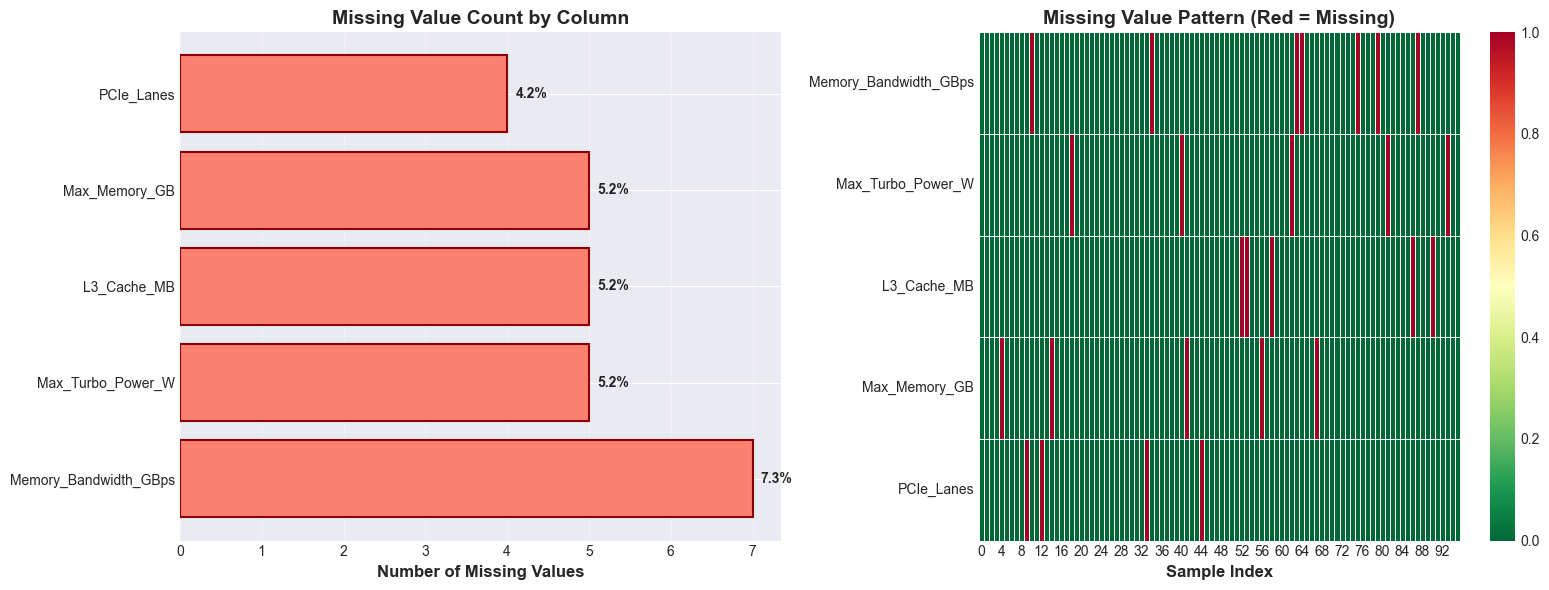

In [72]:
# Visualize missing value patterns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of missing values
if not missing_df.empty:
    axes[0].barh(missing_df['Column'], missing_df['Missing_Count'], color='salmon', edgecolor='darkred', linewidth=1.5)
    axes[0].set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
    axes[0].set_title('Missing Value Count by Column', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (count, pct) in enumerate(zip(missing_df['Missing_Count'], missing_df['Missing_Percentage'])):
        axes[0].text(count + 0.1, i, f'{pct:.1f}%', va='center', fontweight='bold')

# Heatmap of missing values (subset of data with missing values)
cols_with_missing = missing_df['Column'].tolist()
if cols_with_missing:
    missing_matrix = df_original[cols_with_missing].isnull().astype(int)
    sns.heatmap(missing_matrix.T, cmap='RdYlGn_r', cbar=True, yticklabels=cols_with_missing, 
                ax=axes[1], linewidths=0.5)
    axes[1].set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    axes[1].set_title('Missing Value Pattern (Red = Missing)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Step 4: Missing Value Imputation - Comparison of Methods

We'll compare three imputation strategies:
1. **Mean Imputation**: Simple but ignores correlations
2. **Median Imputation**: Robust to outliers
3. **KNN Imputation**: Preserves feature relationships (k=5 neighbors)

In [73]:
from sklearn.impute import SimpleImputer, KNNImputer

# Separate numerical columns for imputation
numerical_cols_with_missing = ['Max_Turbo_Power_W', 'L3_Cache_MB', 'PCIe_Lanes', 
                                'Max_Memory_GB', 'Memory_Bandwidth_GBps']

# Get all numerical columns
numerical_cols = df_original.select_dtypes(include=[np.number]).columns.tolist()

print("Testing 3 imputation strategies on numerical features...")
print("="*70)

# Strategy 1: Mean Imputation
df_mean = df_original.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean[numerical_cols] = mean_imputer.fit_transform(df_mean[numerical_cols])
print("✓ Mean Imputation completed")

# Strategy 2: Median Imputation
df_median = df_original.copy()
median_imputer = SimpleImputer(strategy='median')
df_median[numerical_cols] = median_imputer.fit_transform(df_median[numerical_cols])
print("✓ Median Imputation completed")

# Strategy 3: KNN Imputation (k=5)
df_knn = df_original.copy()
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df_knn[numerical_cols] = knn_imputer.fit_transform(df_knn[numerical_cols])
print("✓ KNN Imputation (k=5) completed")

print("="*70)
print("\nAll imputation strategies applied successfully!")
print(f"No remaining missing values in numerical columns: {df_knn[numerical_cols].isnull().sum().sum() == 0}")

Testing 3 imputation strategies on numerical features...
✓ Mean Imputation completed
✓ Median Imputation completed
✓ KNN Imputation (k=5) completed

All imputation strategies applied successfully!
No remaining missing values in numerical columns: True


In [74]:
# Compare imputed values for columns with missing data
print("="*90)
print("COMPARISON OF IMPUTATION METHODS")
print("="*90)

for col in numerical_cols_with_missing:
    missing_indices = df_original[df_original[col].isnull()].index[:3]  # Show first 3 examples
    
    if len(missing_indices) > 0:
        print(f"\n📊 {col}:")
        print("-" * 90)
        
        comparison_data = {
            'Index': missing_indices,
            'Original': ['MISSING'] * len(missing_indices),
            'Mean': df_mean.loc[missing_indices, col].round(2).values,
            'Median': df_median.loc[missing_indices, col].round(2).values,
            'KNN (k=5)': df_knn.loc[missing_indices, col].round(2).values
        }
        
        comp_df = pd.DataFrame(comparison_data)
        print(comp_df.to_string(index=False))
        
        # Calculate statistics
        print(f"\nColumn Statistics:")
        print(f"  Mean value: {df_original[col].mean():.2f}")
        print(f"  Median value: {df_original[col].median():.2f}")
        print(f"  Std deviation: {df_original[col].std():.2f}")

print("\n" + "="*90)

COMPARISON OF IMPUTATION METHODS

📊 Max_Turbo_Power_W:
------------------------------------------------------------------------------------------
 Index Original   Mean  Median  KNN (k=5)
    18  MISSING 137.36   142.0     137.57
    40  MISSING 137.36   142.0     160.52
    62  MISSING 137.36   142.0     179.80

Column Statistics:
  Mean value: 137.36
  Median value: 142.00
  Std deviation: 63.87

📊 L3_Cache_MB:
------------------------------------------------------------------------------------------
 Index Original  Mean  Median  KNN (k=5)
    52  MISSING 32.31    25.0      19.42
    53  MISSING 32.31    25.0      16.90
    58  MISSING 32.31    25.0      23.52

Column Statistics:
  Mean value: 32.31
  Median value: 25.00
  Std deviation: 22.23

📊 PCIe_Lanes:
------------------------------------------------------------------------------------------
 Index Original  Mean  Median  KNN (k=5)
     9  MISSING 20.61    20.0      21.96
    12  MISSING 20.61    20.0      20.00
    33  MISSIN

## Step 5: Select Best Imputation Strategy

Based on analysis, we'll use **KNN Imputation (k=5)** as it:
- Preserves feature correlations (e.g., Max_Turbo_Power_W correlates with TDP_W and Cores)
- Handles outliers better than mean
- Uses nearest neighbors to estimate realistic values

In [75]:
# Use KNN-imputed dataset for further analysis
df = df_knn.copy()

print("="*70)
print("FINAL DATASET AFTER KNN IMPUTATION")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Missing values remaining: {df.isnull().sum().sum()}")
print(f"\nDataset ready for feature engineering and model training!")
print("="*70)

FINAL DATASET AFTER KNN IMPUTATION
Shape: (96, 27)
Missing values remaining: 0

Dataset ready for feature engineering and model training!


In [76]:
# Load the CPU dataset
df = pd.read_csv('cpu_performance_dataset.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"   - Total CPUs: {df.shape[0]}")
print(f"   - Total Features: {df.shape[1]}")
print(f"\nFirst 5 rows:")
df.head()


Dataset Shape: (96, 43)
   - Total CPUs: 96
   - Total Features: 43

First 5 rows:


,Brand,Model,Type,Year,Cores,P_Cores,E_Cores,Threads,Base_Clock_GHz,Boost_Clock_GHz,...,Performance_Per_Dollar,Cache_Per_Core_MB,P_Core_Percentage,Turbo_Power_Headroom_W,Memory_Bandwidth_GBps,Process_Efficiency,CPU_Category,Price_Range,Generation,Performance_Tier
0,Intel,Core i9-13980HX,Laptop,2023,24,8,16,32,2.2,5.6,...,69.732258,1.500,33.333333,102,89.6,78.607273,Mobile Workstation,Enthusiast,Intel 13th Gen,High-End
1,Intel,Core i9-13950HX,Laptop,2023,24,8,16,32,2.2,5.5,...,70.311475,1.500,33.333333,102,89.6,77.981818,Mobile Workstation,Enthusiast,Intel 13th Gen,High-End
2,Intel,Core i9-13900HX,Laptop,2023,24,8,16,32,2.2,5.4,...,70.945000,1.500,33.333333,102,89.6,77.394545,Mobile Workstation,High-End,Intel 13th Gen,High-End
3,Intel,Core i7-13850HX,Laptop,2023,20,6,14,28,2.1,5.3,...,75.056604,1.800,30.000000,102,89.6,72.327273,Mobile Workstation,High-End,Intel 13th Gen,High-End
4,Intel,Core i7-13700HX,Laptop,2023,16,8,8,24,2.1,5.0,...,80.116667,1.875,50.000000,102,89.6,69.920000,Mobile Workstation,High-End,Intel 13th Gen,High-End


In [77]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   96 non-null     object 
 1   Model                   96 non-null     object 
 2   Type                    96 non-null     object 
 3   Year                    96 non-null     int64  
 4   Cores                   96 non-null     int64  
 5   P_Cores                 96 non-null     int64  
 6   E_Cores                 96 non-null     int64  
 7   Threads                 96 non-null     int64  
 8   Base_Clock_GHz          96 non-null     float64
 9   Boost_Clock_GHz         96 non-null     float64
 10  TDP_W                   96 non-null     int64  
 11  Max_Turbo_Power_W       96 non-null     int64  
 12  Cache_MB                96 non-null     int64  
 13  L3_Cache_MB             96 non-null     int64  
 14  Price_USD               96 non-null     int6

In [78]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,96.0,2022.750000,0.710819,2022.000000,2022.000000,2023.000000,2023.000000,2024.000000
Cores,96.0,12.166667,5.533946,4.000000,8.000000,12.000000,16.000000,24.000000
P_Cores,96.0,7.520833,2.623694,4.000000,6.000000,8.000000,8.000000,16.000000
E_Cores,96.0,4.645833,5.331099,0.000000,0.000000,4.000000,8.000000,16.000000
Threads,96.0,19.708333,6.848614,8.000000,16.000000,18.000000,24.000000,32.000000
Base_Clock_GHz,96.0,3.130208,0.725929,2.000000,2.500000,3.250000,3.625000,4.700000
Boost_Clock_GHz,96.0,5.008333,0.436353,4.200000,4.675000,5.000000,5.400000,6.000000
TDP_W,96.0,75.718750,37.123890,15.000000,45.000000,65.000000,120.000000,170.000000
Max_Turbo_Power_W,96.0,138.385417,63.444028,25.000000,88.000000,145.000000,180.250000,253.000000
Cache_MB,96.0,34.968750,24.199806,12.000000,22.000000,25.000000,36.000000,144.000000


#### Check for missing values

In [79]:

missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found!")
else:
    print(missing[missing > 0])

iGPU    21
dtype: int64


In [80]:
# Dataset breakdown by categories
print("\nDATASET BREAKDOWN")
print("="*70)

print("\nBy Brand:")
print(df['Brand'].value_counts())

print("\nBy Type:")
print(df['Type'].value_counts())

print("\nBy Year:")
print(df['Year'].value_counts().sort_index())

print("\nBy Generation:")
print(df['Generation'].value_counts())

print("\nBy CPU Category:")
print(df['CPU_Category'].value_counts())


DATASET BREAKDOWN

By Brand:
Brand
Intel    55
AMD      41
Name: count, dtype: int64

By Type:
Type
Desktop    59
Laptop     37
Name: count, dtype: int64

By Year:
Year
2022    39
2023    42
2024    15
Name: count, dtype: int64

By Generation:
Generation
Intel 13th Gen    25
AMD Ryzen 7000    19
Intel 12th Gen    18
Intel 14th Gen    11
AMD Ryzen 5000    10
AMD Ryzen 6000     8
AMD Ryzen 9000     4
Other              1
Name: count, dtype: int64

By CPU Category:
CPU_Category
Mainstream                 24
High-Performance Gaming    20
Mainstream Laptop          16
Mobile Workstation         13
Workstation/Enthusiast     12
High-Performance Laptop     8
Budget                      3
Name: count, dtype: int64


## Step 3: Exploratory Data Analysis (EDA)

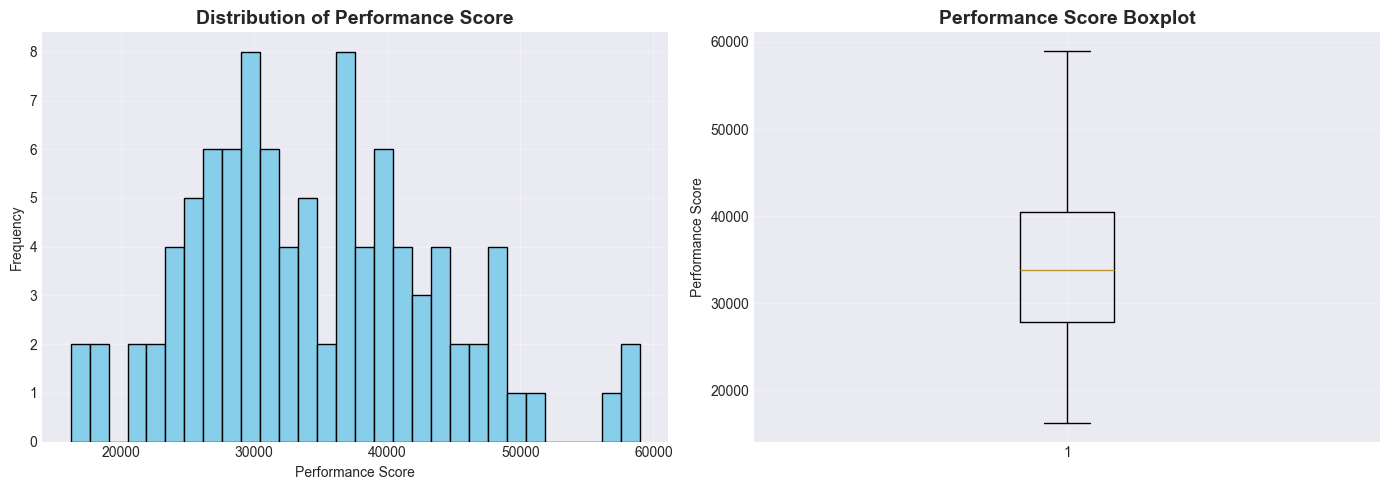


Performance Score Statistics:
   - Mean: 34595.17
   - Median: 33845.00
   - Std Dev: 9206.64
   - Min: 16234.00
   - Max: 58967.00


In [81]:
# Distribution of target variable (Performance Score)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Performance_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Performance Score', fontsize=14, fontweight='bold')
plt.xlabel('Performance Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['Performance_Score'], vert=True)
plt.title('Performance Score Boxplot', fontsize=14, fontweight='bold')
plt.ylabel('Performance Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPerformance Score Statistics:")
print(f"   - Mean: {df['Performance_Score'].mean():.2f}")
print(f"   - Median: {df['Performance_Score'].median():.2f}")
print(f"   - Std Dev: {df['Performance_Score'].std():.2f}")
print(f"   - Min: {df['Performance_Score'].min():.2f}")
print(f"   - Max: {df['Performance_Score'].max():.2f}")

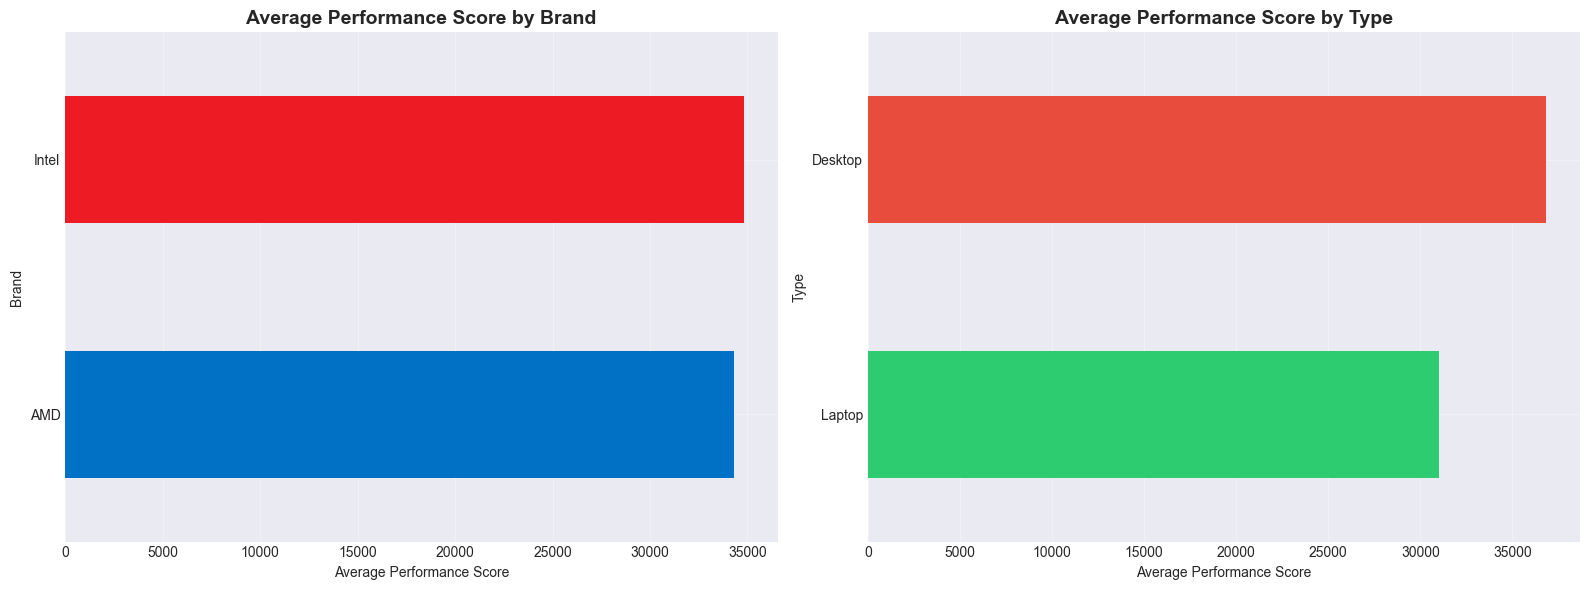

In [82]:
# Performance Score by Brand and Type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By Brand
df.groupby('Brand')['Performance_Score'].mean().sort_values().plot(
    kind='barh', ax=axes[0], color=['#0071C5', '#ED1C24']
)
axes[0].set_title('Average Performance Score by Brand', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Performance Score')
axes[0].grid(True, alpha=0.3)

# By Type
df.groupby('Type')['Performance_Score'].mean().sort_values().plot(
    kind='barh', ax=axes[1], color=['#2ECC71', '#E74C3C']
)
axes[1].set_title('Average Performance Score by Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Performance Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

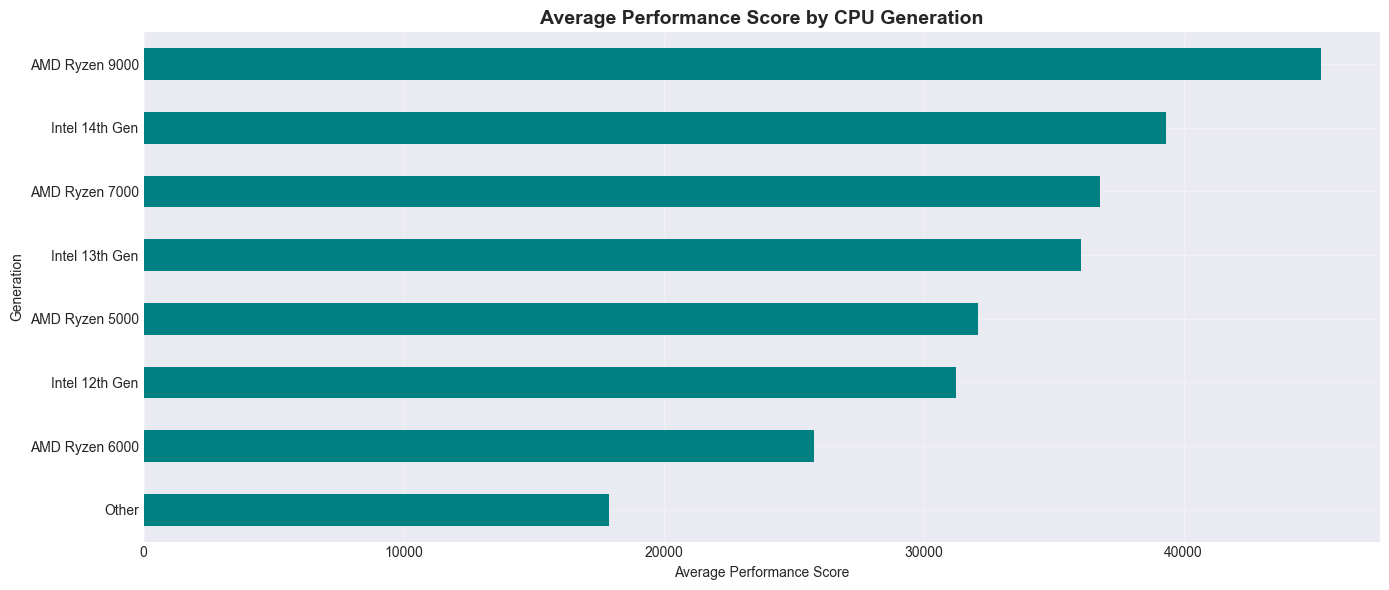

In [83]:
# Performance Score by Generation
plt.figure(figsize=(14, 6))
df.groupby('Generation')['Performance_Score'].mean().sort_values().plot(
    kind='barh', color='teal'
)
plt.title('Average Performance Score by CPU Generation', fontsize=14, fontweight='bold')
plt.xlabel('Average Performance Score')
plt.ylabel('Generation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# Correlation Analysis - Numerical Features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove non-predictive columns
exclude_cols = ['Performance_Score']
feature_cols = [col for col in numerical_cols if col not in exclude_cols]

# Calculate correlations with target
correlations = df[feature_cols + ['Performance_Score']].corr()['Performance_Score'].sort_values(ascending=False)
print("\nCORRELATION WITH PERFORMANCE SCORE")
print("="*70)
print(correlations[1:16])


CORRELATION WITH PERFORMANCE SCORE
Threads                   0.883487
Boost_Clock_GHz           0.872250
Price_USD                 0.835751
P_Cores                   0.766635
Cores                     0.727761
L3_Cache_MB               0.703524
Max_Turbo_Power_W         0.697154
Cache_MB                  0.681090
TDP_W                     0.667481
PCIe_Lanes                0.501469
Max_Memory_GB             0.468827
PCIe_Gen                  0.466657
Turbo_Power_Headroom_W    0.462848
Year                      0.390985
E_Cores                   0.378154
Name: Performance_Score, dtype: float64


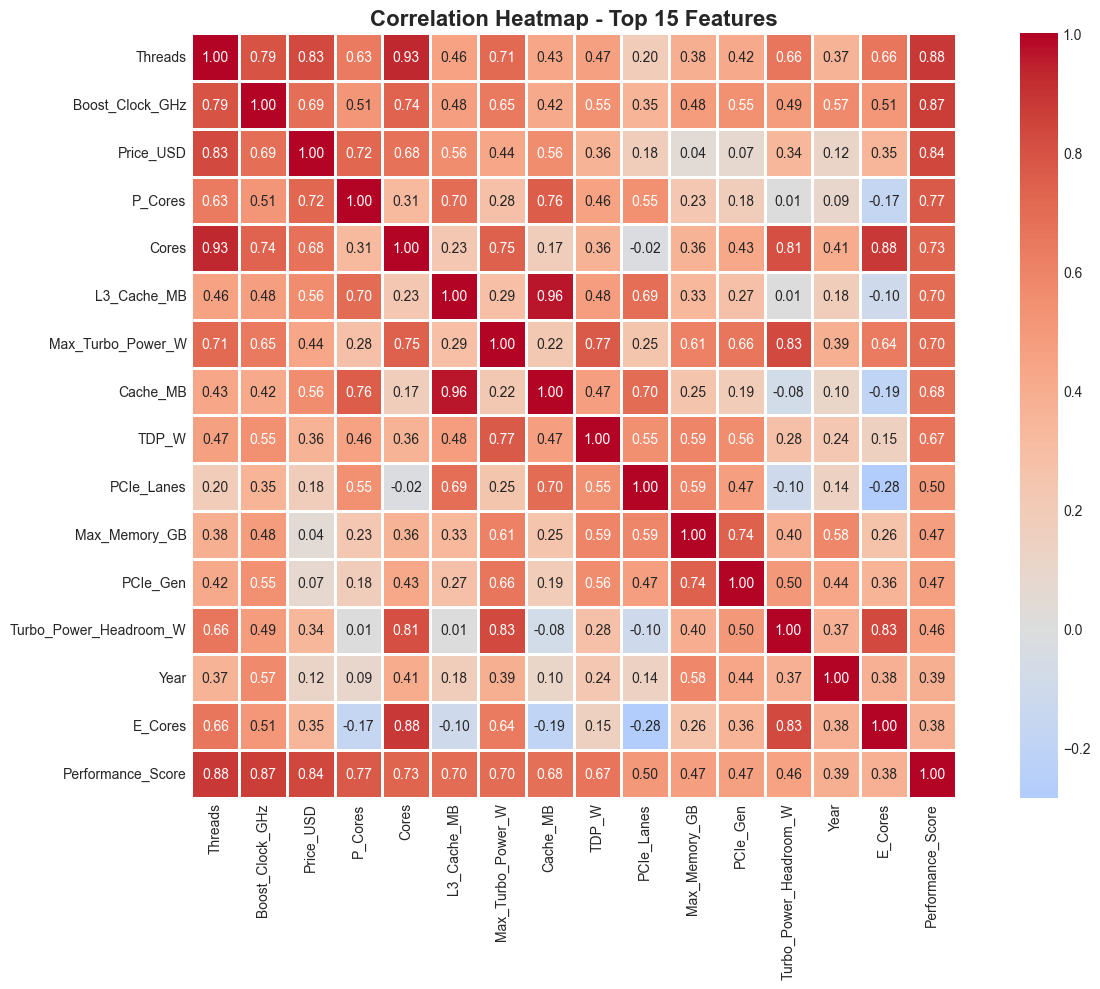

In [85]:
# Correlation heatmap for top features
top_features = correlations[1:16].index.tolist() + ['Performance_Score']

plt.figure(figsize=(14, 10))
sns.heatmap(
    df[top_features].corr(), 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1
)
plt.title('Correlation Heatmap - Top 15 Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

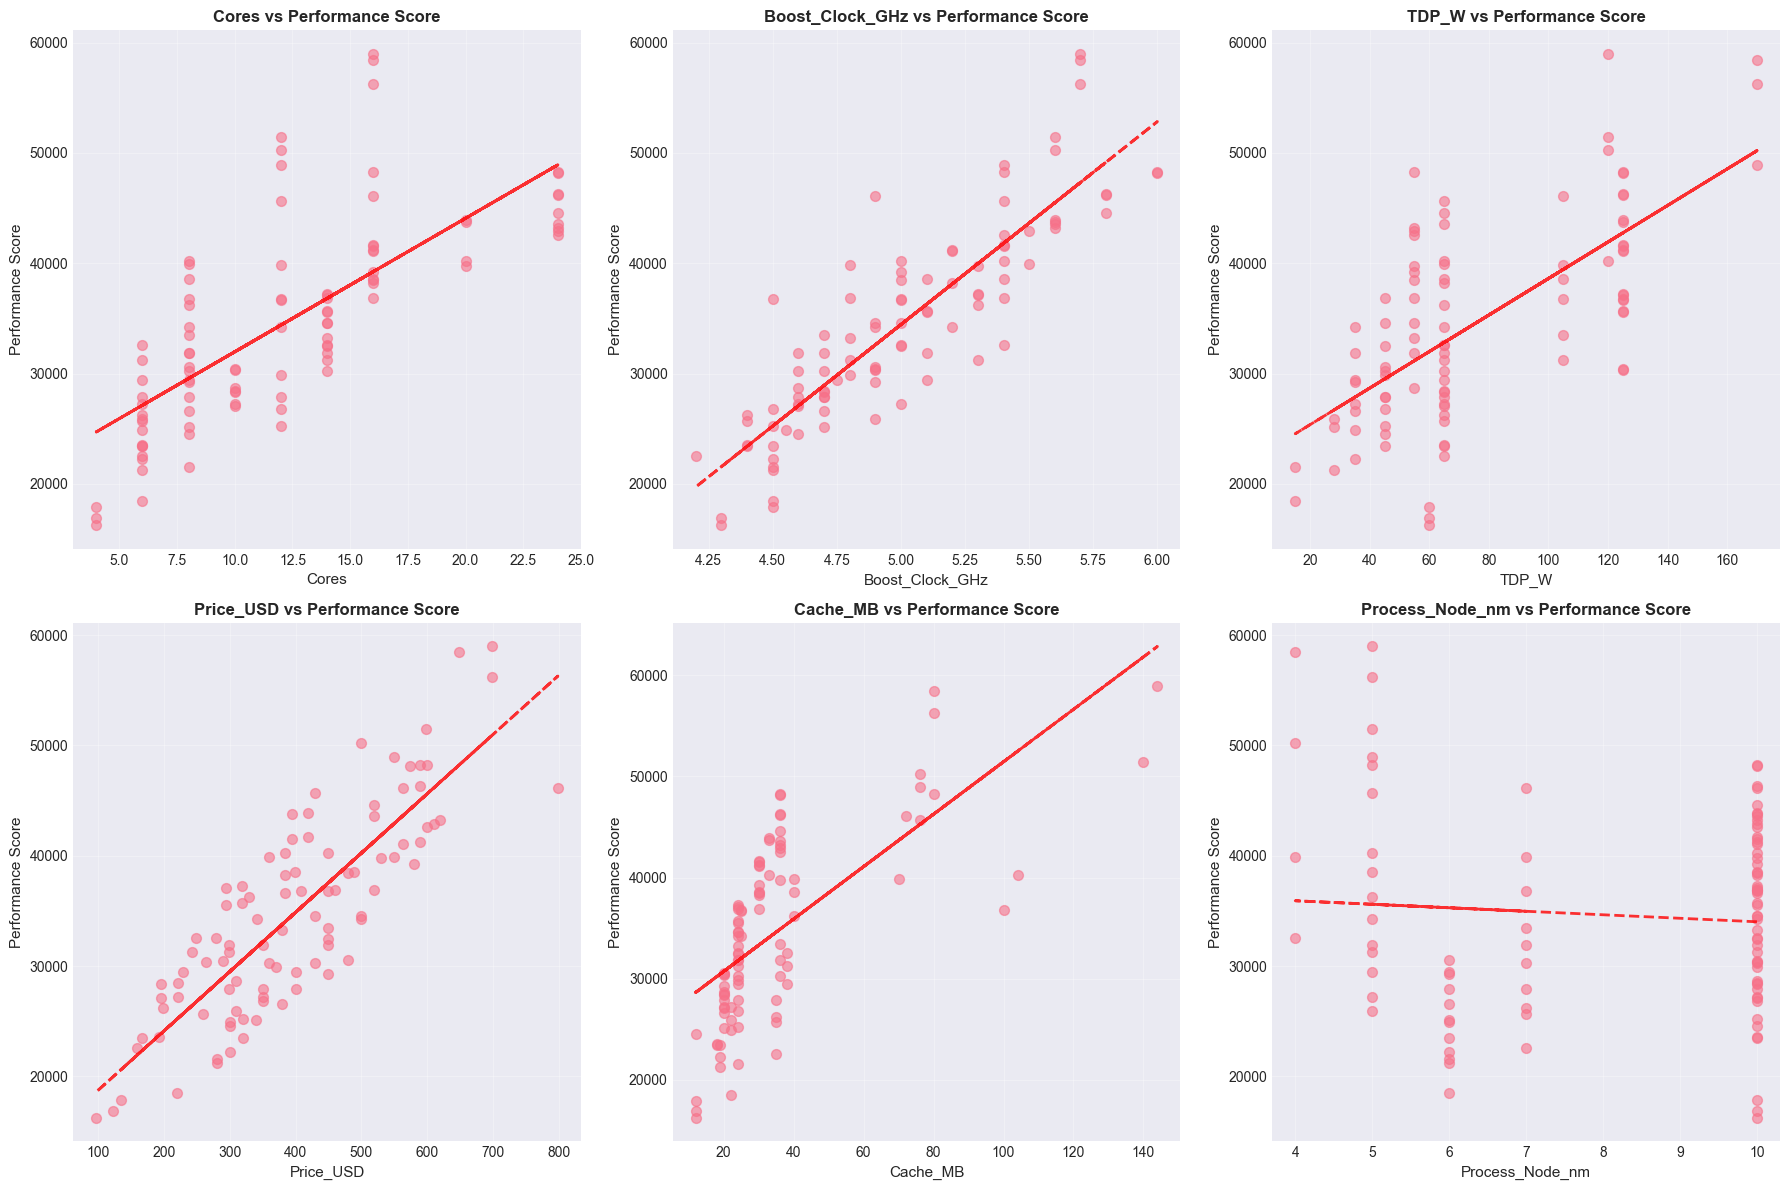

In [86]:
# Scatter plots - Key features vs Performance Score
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

key_features = ['Cores', 'Boost_Clock_GHz', 'TDP_W', 'Price_USD', 'Cache_MB', 'Process_Node_nm']

for idx, feature in enumerate(key_features):
    axes[idx].scatter(df[feature], df['Performance_Score'], alpha=0.6, s=50)
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Performance Score', fontsize=11)
    axes[idx].set_title(f'{feature} vs Performance Score', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df[feature], df['Performance_Score'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

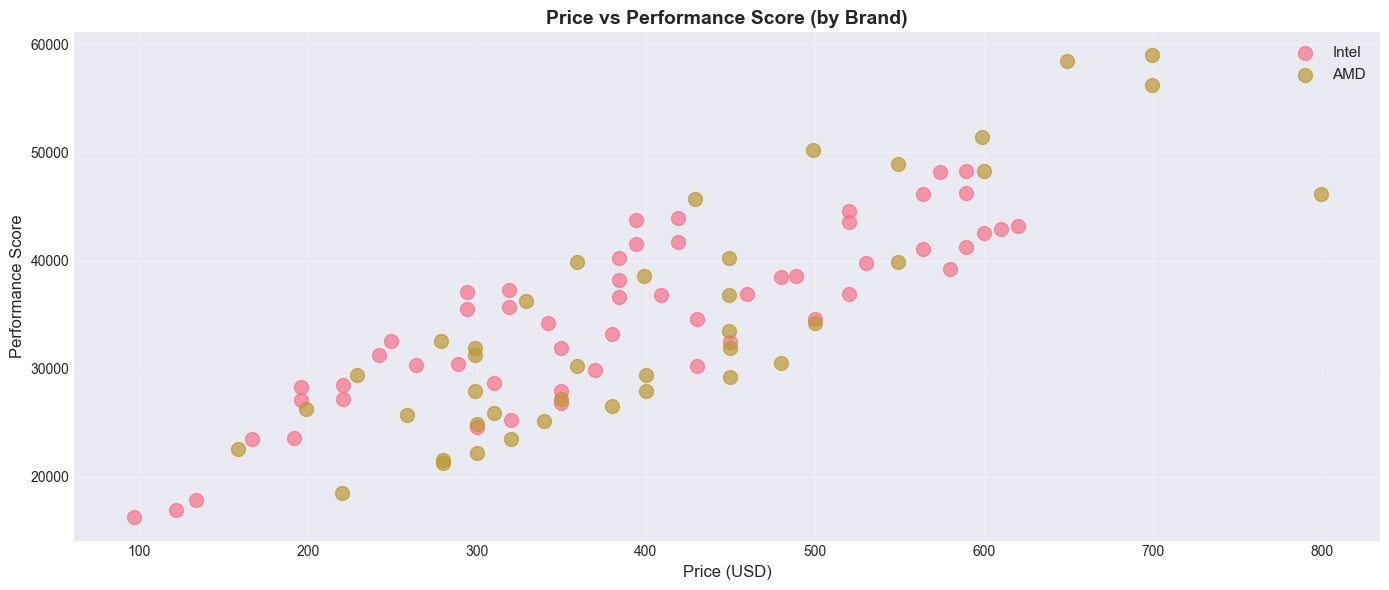


TOP 10 CPUs BY PERFORMANCE PER DOLLAR:
         Model Brand  Price_USD  Performance_Score  Performance_Per_Dollar
Core i3-12100F Intel         97              16234              167.360825
Core i5-14400F Intel        196              28340              144.591837
  Ryzen 5 5500   AMD        159              22567              141.930818
Core i5-12400F Intel        167              23450              140.419162
 Core i3-12100 Intel        122              16890              138.442623
Core i5-13400F Intel        196              27100              138.265306
 Core i3-13100 Intel        134              17890              133.507463
  Ryzen 5 5600   AMD        199              26234              131.829146
 Core i5-14500 Intel        249              32567              130.791165
 Core i5-13500 Intel        242              31234              129.066116


In [87]:
# Price vs Performance Analysis
plt.figure(figsize=(14, 6))

for brand in df['Brand'].unique():
    brand_data = df[df['Brand'] == brand]
    plt.scatter(
        brand_data['Price_USD'], 
        brand_data['Performance_Score'],
        label=brand,
        alpha=0.7,
        s=100
    )

plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Performance Score', fontsize=12)
plt.title('Price vs Performance Score (by Brand)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Performance per Dollar
print("\nTOP 10 CPUs BY PERFORMANCE PER DOLLAR:")
print("="*70)
top_value = df.nlargest(10, 'Performance_Per_Dollar')[['Model', 'Brand', 'Price_USD', 'Performance_Score', 'Performance_Per_Dollar']]
print(top_value.to_string(index=False))

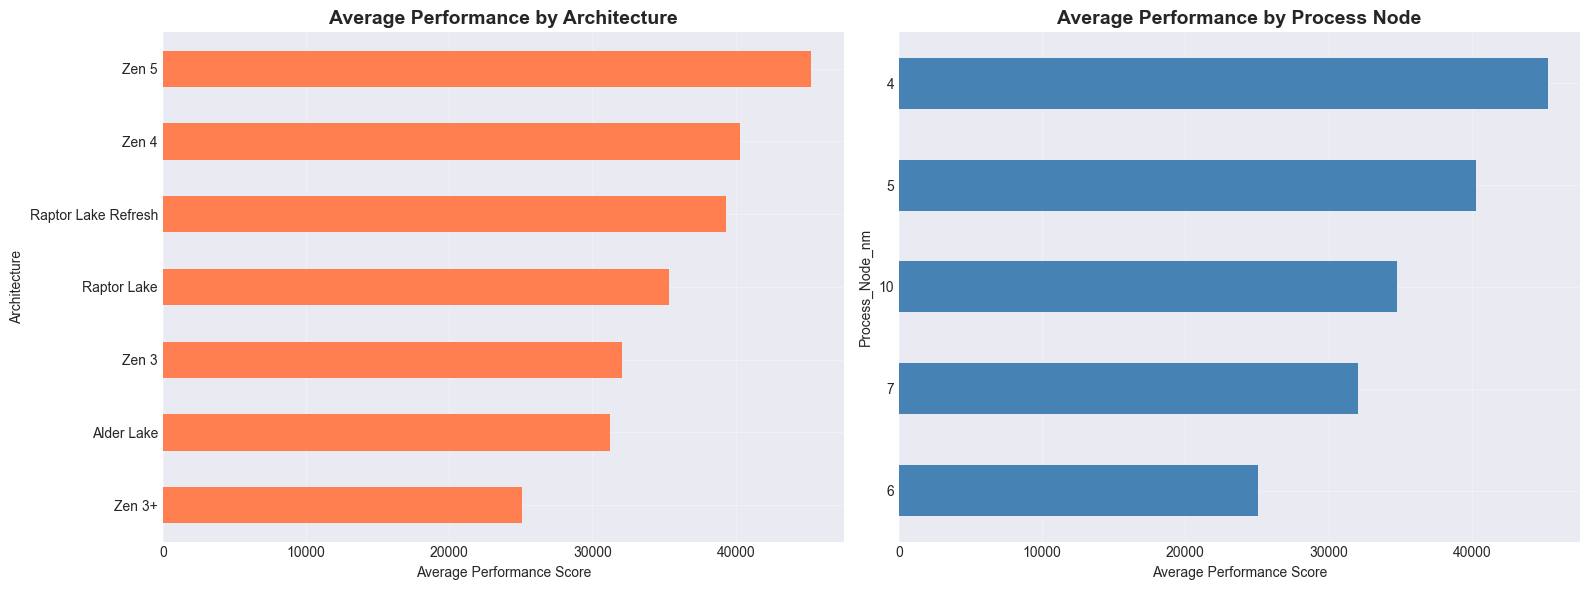

In [88]:
# Architecture and Process Node Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By Architecture
df.groupby('Architecture')['Performance_Score'].mean().sort_values().plot(
    kind='barh', ax=axes[0], color='coral'
)
axes[0].set_title('Average Performance by Architecture', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Performance Score')
axes[0].grid(True, alpha=0.3)

# By Process Node
df.groupby('Process_Node_nm')['Performance_Score'].mean().sort_values().plot(
    kind='barh', ax=axes[1], color='steelblue'
)
axes[1].set_title('Average Performance by Process Node', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Performance Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


INTEL 13TH GEN HX SERIES ANALYSIS

Total HX Models: 9

All Intel 13th Gen HX CPUs:
          Model  Cores  P_Cores  E_Cores  Boost_Clock_GHz  TDP_W  Price_USD  Performance_Score
Core i9-13980HX     24        8       16              5.6     55        620              43234
Core i9-13950HX     24        8       16              5.5     55        610              42890
Core i9-13900HX     24        8       16              5.4     55        600              42567
Core i7-13850HX     20        6       14              5.3     55        530              39780
Core i7-13700HX     16        8        8              5.0     55        480              38456
Core i7-13650HX     14        6        8              4.9     55        430              34567
Core i5-13600HX     14        6        8              4.8     55        380              33240
Core i5-13500HX     14        6        8              4.7     55        350              31890
Core i5-13450HX     10        6        4              4.6    

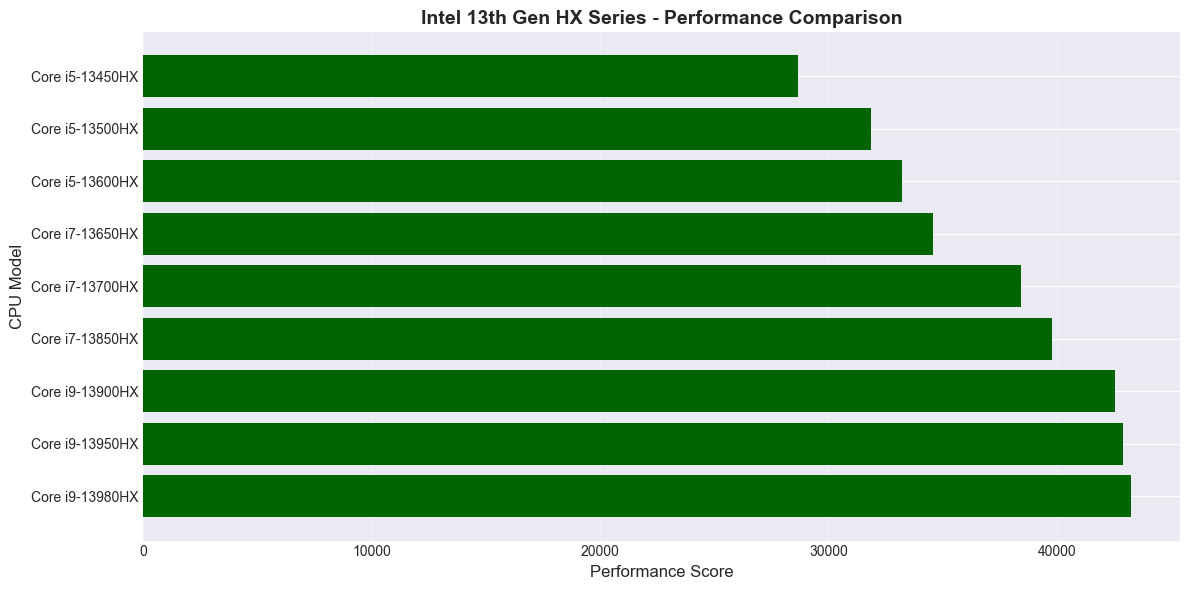

In [89]:
# Intel 13th Gen HX Series Analysis (All 9 models)
print("\nINTEL 13TH GEN HX SERIES ANALYSIS")
print("="*70)

hx_series = df[df['Model'].str.contains('13.*HX', regex=True, na=False)].copy()
hx_series_sorted = hx_series.sort_values('Performance_Score', ascending=False)

print(f"\nTotal HX Models: {len(hx_series_sorted)}")
print("\nAll Intel 13th Gen HX CPUs:")
print(hx_series_sorted[['Model', 'Cores', 'P_Cores', 'E_Cores', 'Boost_Clock_GHz', 
                         'TDP_W', 'Price_USD', 'Performance_Score']].to_string(index=False))

# Visualize HX Series
plt.figure(figsize=(12, 6))
plt.barh(hx_series_sorted['Model'], hx_series_sorted['Performance_Score'], color='darkgreen')
plt.xlabel('Performance Score', fontsize=12)
plt.ylabel('CPU Model', fontsize=12)
plt.title('Intel 13th Gen HX Series - Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Step 4: Data Preprocessing & Feature Engineering

In [90]:
# Identify feature types
print("\nFEATURE TYPES IDENTIFICATION")
print("="*70)

# Numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Performance_Score')  # Remove target

# Categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical Features ({len(numerical_features)}):")
print(numerical_features[:15], "...")

print(f"\nCategorical Features ({len(categorical_features)}):")
print(categorical_features)


FEATURE TYPES IDENTIFICATION

Numerical Features (29):
['Year', 'Cores', 'P_Cores', 'E_Cores', 'Threads', 'Base_Clock_GHz', 'Boost_Clock_GHz', 'TDP_W', 'Max_Turbo_Power_W', 'Cache_MB', 'L3_Cache_MB', 'Price_USD', 'Process_Node_nm', 'PCIe_Gen', 'PCIe_Lanes'] ...

Categorical Features (13):
['Brand', 'Model', 'Type', 'Architecture', 'Memory_Type', 'iGPU', 'Unlocked', 'Hyper_Threading', 'Release_Quarter', 'CPU_Category', 'Price_Range', 'Generation', 'Performance_Tier']


In [91]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop non-predictive columns and Price_USD (not an important feature)
columns_to_drop = ['Model', 'Price_USD']  # Model name and Price_USD are not useful for prediction
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print("Dropped non-predictive columns:")
print(f"   - {', '.join(columns_to_drop)}")
print(f"\nRemaining columns: {df_processed.shape[1]}")

Dropped non-predictive columns:
   - Model, Price_USD

Remaining columns: 41


In [92]:
# Display remaining features after dropping Price_USD
print("\nREMAINING FEATURES AFTER REMOVAL:")
print("="*70)
print(f"Total features: {len(df_processed.columns) - 1}")  # -1 for target
print("\nFeature list:")
remaining_features = [col for col in df_processed.columns if col != 'Performance_Score']
for i, feature in enumerate(remaining_features, 1):
    print(f"   {i}. {feature}")


REMAINING FEATURES AFTER REMOVAL:
Total features: 40

Feature list:
   1. Brand
   2. Type
   3. Year
   4. Cores
   5. P_Cores
   6. E_Cores
   7. Threads
   8. Base_Clock_GHz
   9. Boost_Clock_GHz
   10. TDP_W
   11. Max_Turbo_Power_W
   12. Cache_MB
   13. L3_Cache_MB
   14. Architecture
   15. Process_Node_nm
   16. PCIe_Gen
   17. PCIe_Lanes
   18. Max_Memory_GB
   19. Memory_Channels
   20. Memory_Type
   21. Memory_Speed_MHz
   22. iGPU
   23. iGPU_Cores
   24. iGPU_Frequency_MHz
   25. Unlocked
   26. Hyper_Threading
   27. Release_Quarter
   28. Cores_Threads_Ratio
   29. Clock_Range_GHz
   30. Performance_Per_Watt
   31. Performance_Per_Dollar
   32. Cache_Per_Core_MB
   33. P_Core_Percentage
   34. Turbo_Power_Headroom_W
   35. Memory_Bandwidth_GBps
   36. Process_Efficiency
   37. CPU_Category
   38. Price_Range
   39. Generation
   40. Performance_Tier


In [93]:
# Separate features and target
X = df_processed.drop('Performance_Score', axis=1)
y = df_processed['Performance_Score']

print("\nFEATURES AND TARGET SEPARATED")
print("="*70)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget variable: Performance_Score")
print(f"Number of features: {X.shape[1]}")


FEATURES AND TARGET SEPARATED
Features shape: (96, 40)
Target shape: (96,)

Target variable: Performance_Score
Number of features: 40


#### Encode categorical variables

In [94]:
# Update categorical features list (after dropping Model)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Label encoding for categorical variables
label_encoders = {}
X_encoded = X.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded: {col} ({len(le.classes_)} unique values)")

print(f"\nEncoded dataset shape: {X_encoded.shape}")

Encoded: Brand (2 unique values)
Encoded: Type (2 unique values)
Encoded: Architecture (7 unique values)
Encoded: Memory_Type (4 unique values)
Encoded: iGPU (11 unique values)
Encoded: Unlocked (3 unique values)
Encoded: Hyper_Threading (1 unique values)
Encoded: Release_Quarter (8 unique values)
Encoded: CPU_Category (7 unique values)
Encoded: Price_Range (4 unique values)
Encoded: Generation (8 unique values)
Encoded: Performance_Tier (4 unique values)

Encoded dataset shape: (96, 40)


In [95]:
# Check for any remaining issues
print(f"\nMissing values in features: {X_encoded.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")
print(f"\nData types:")
print(X_encoded.dtypes.value_counts())

if X_encoded.isnull().sum().sum() == 0 and y.isnull().sum() == 0:
    print("\nData is clean and ready for modeling!")
else:
    print("\nWarning: Missing values detected!")


Missing values in features: 0
Missing values in target: 0

Data types:
int64      30
float64    10
Name: count, dtype: int64

Data is clean and ready for modeling!


## Step 5: Train-Test Split

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nTraining Set:")
print(f"   - X_train shape: {X_train.shape}")
print(f"   - y_train shape: {y_train.shape}")
print(f"   - Training samples: {len(X_train)} ({len(X_train)/len(X_encoded)*100:.1f}%)")

print(f"\nTesting Set:")
print(f"   - X_test shape: {X_test.shape}")
print(f"   - y_test shape: {y_test.shape}")
print(f"   - Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded)*100:.1f}%)")

print(f"\nTarget Variable Range:")
print(f"   - Training: {y_train.min():.0f} - {y_train.max():.0f}")
print(f"   - Testing: {y_test.min():.0f} - {y_test.max():.0f}")


Training Set:
   - X_train shape: (76, 40)
   - y_train shape: (76,)
   - Training samples: 76 (79.2%)

Testing Set:
   - X_test shape: (20, 40)
   - y_test shape: (20,)
   - Testing samples: 20 (20.8%)

Target Variable Range:
   - Training: 16234 - 58967
   - Testing: 17890 - 48234


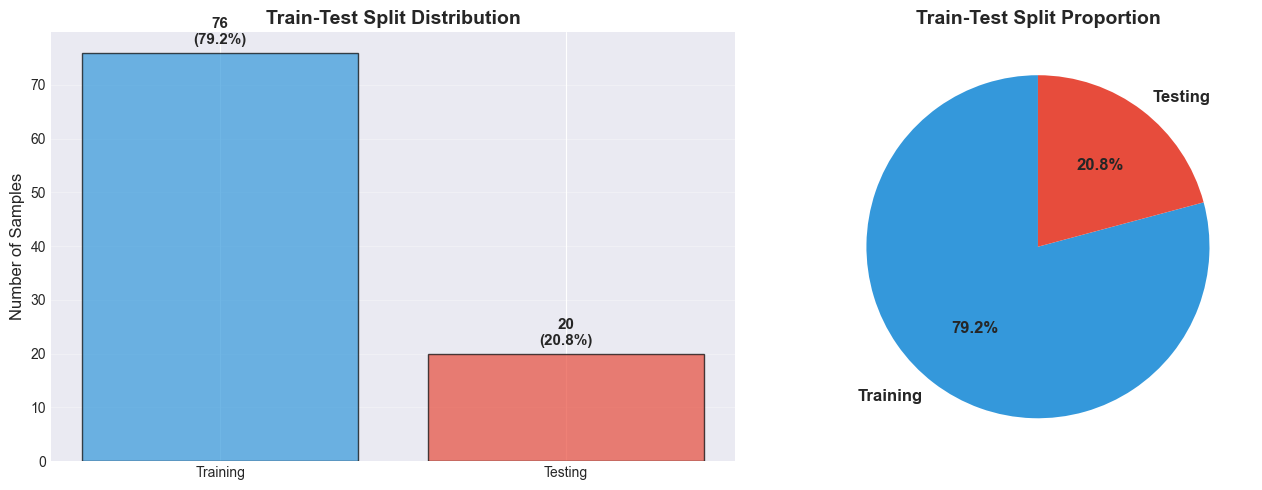

In [97]:
# Visualize train-test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dataset split distribution
split_data = ['Training', 'Testing']
split_counts = [len(X_train), len(X_test)]
colors = ['#3498db', '#e74c3c']

axes[0].bar(split_data, split_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Train-Test Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (label, count) in enumerate(zip(split_data, split_counts)):
    axes[0].text(i, count + 1, f'{count}\n({count/len(X_encoded)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(split_counts, labels=split_data, colors=colors, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Train-Test Split Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Step 6: Feature Scaling

In [98]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nStandardScaler applied to training and testing sets")
print(f"\nScaled Training Set:")
print(f"   - Mean: {X_train_scaled.mean():.6f}")
print(f"   - Std: {X_train_scaled.std():.6f}")

print(f"\nScaled Testing Set:")
print(f"   - Mean: {X_test_scaled.mean():.6f}")
print(f"   - Std: {X_test_scaled.std():.6f}")

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nData is now scaled and ready for machine learning models!")


StandardScaler applied to training and testing sets

Scaled Training Set:
   - Mean: 0.000000
   - Std: 0.974679

Scaled Testing Set:
   - Mean: 0.009619
   - Std: 1.064303

Data is now scaled and ready for machine learning models!


Scaled Training Set:
   - Mean: 0.000000
   - Std: 0.974679

Scaled Testing Set:
   - Mean: 0.009619
   - Std: 1.064303

Data is now scaled and ready for machine learning models!


In [99]:
# Display the complete scaled training dataset
print(f"\nShape: {X_train_scaled_df.shape}")
print(f"\nComplete Scaled Training Data:\n")
display(X_train_scaled_df)

# Display the complete scaled testing dataset
print(f"\nShape: {X_test_scaled_df.shape}")
print(f"\nComplete Scaled Testing Data:\n")
display(X_test_scaled_df)


Shape: (76, 40)

Complete Scaled Training Data:



,Brand,Type,Year,Cores,P_Cores,E_Cores,Threads,Base_Clock_GHz,Boost_Clock_GHz,TDP_W,...,Performance_Per_Dollar,Cache_Per_Core_MB,P_Core_Percentage,Turbo_Power_Headroom_W,Memory_Bandwidth_GBps,Process_Efficiency,CPU_Category,Price_Range,Generation,Performance_Tier
40,0.876038,-0.785507,-1.007691,-0.009985,0.171560,-0.097056,0.056169,0.607711,-0.040196,1.307022,...,0.097087,-0.542037,-0.184669,0.074692,-0.322335,-1.031076,-1.334287,0.789015,0.341674,-0.012592
67,-1.141504,-0.785507,0.384755,-1.148222,-0.595413,-0.873507,-1.163505,2.124268,0.664781,0.773113,...,0.492713,1.631591,0.991906,-0.604556,0.275164,-0.348439,-0.161966,0.789015,-0.740293,0.944387
15,0.876038,-0.785507,1.777201,2.266490,0.171560,2.232296,1.885681,-1.598190,1.839744,-0.294703,...,-0.328304,-0.840378,-1.361245,2.233731,0.872664,-0.143828,1.596517,-0.321451,1.423641,-0.012592
68,-1.141504,-0.785507,-1.007691,-1.148222,-0.595413,-0.873507,-1.163505,0.883449,0.194796,-0.294703,...,1.546936,1.631591,0.991906,-0.944181,0.275164,0.355116,-0.161966,0.789015,-0.740293,0.944387
88,-1.141504,1.273063,-1.007691,-0.768809,0.171560,-0.873507,-0.553668,0.194105,-0.275189,-0.828612,...,-1.290521,-0.328936,0.991906,-0.774369,-0.322335,0.865546,1.010356,-0.321451,-1.281277,0.944387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-1.141504,-0.785507,0.384755,0.748840,3.239451,-0.873507,1.885681,1.848531,1.604751,2.508316,...,-0.557955,0.949669,0.991906,-0.046603,0.275164,-0.198245,1.596517,-1.431916,-0.740293,-0.969570
71,-1.141504,1.273063,0.384755,-0.768809,0.171560,-0.873507,-0.553668,0.883449,0.194796,-1.095566,...,-0.976601,-0.073215,0.991906,-1.041216,0.275164,2.425902,0.424195,-0.321451,-0.740293,0.944387
14,0.876038,-0.785507,1.777201,0.369428,-0.595413,0.679394,0.056169,0.469842,0.664781,1.307022,...,1.440409,-0.730784,-1.025080,-0.143638,0.872664,-1.022937,-0.161966,0.789015,1.423641,-0.012592
92,-1.141504,1.273063,-1.007691,-0.768809,0.171560,-0.873507,-0.553668,-0.633108,-0.745174,-1.282434,...,-0.844465,-0.328936,0.991906,-1.453617,-0.322335,1.686912,0.424195,0.789015,-1.281277,0.944387



Shape: (20, 40)

Complete Scaled Testing Data:



,Brand,Type,Year,Cores,P_Cores,E_Cores,Threads,Base_Clock_GHz,Boost_Clock_GHz,TDP_W,...,Performance_Per_Dollar,Cache_Per_Core_MB,P_Core_Percentage,Turbo_Power_Headroom_W,Memory_Bandwidth_GBps,Process_Efficiency,CPU_Category,Price_Range,Generation,Performance_Tier
80,-1.141504,-0.785507,-1.007691,-0.768809,0.171560,-0.873507,-0.553668,0.331974,-1.215159,0.773113,...,-0.493025,4.785483,0.991906,-0.604556,-2.712335,-0.562340,-1.334287,-0.321451,-1.822260,-0.012592
77,-1.141504,1.273063,0.384755,-1.148222,-0.595413,-0.873507,-1.163505,-1.598190,-1.215159,-1.629474,...,-0.407593,0.267746,0.991906,-1.259546,-0.322335,2.942228,0.424195,0.789015,-0.740293,-1.926549
73,-1.141504,1.273063,0.384755,-1.148222,-0.595413,-0.873507,-1.163505,1.572793,-0.040196,-1.095566,...,-0.673196,0.267746,0.991906,-1.041216,-0.322335,1.824396,0.424195,0.789015,-0.740293,0.944387
94,-1.141504,1.273063,-1.007691,-1.148222,-0.595413,-0.873507,-1.163505,0.194105,-1.215159,-1.095566,...,-0.834760,0.012025,0.991906,-1.041216,-0.322335,0.699717,0.424195,0.789015,-1.281277,-1.926549
33,0.876038,1.273063,0.384755,0.369428,-0.595413,0.679394,0.056169,-1.046715,-0.040196,-0.828612,...,-0.921651,-0.730784,-1.025080,0.195986,0.275164,-0.063347,-0.748126,-0.321451,0.882657,0.944387
79,-1.141504,-0.785507,-1.007691,-0.009985,1.705505,-0.873507,0.666006,0.745580,-0.510181,0.773113,...,-0.899395,1.375870,0.991906,-0.604556,-2.712335,-0.467386,-1.334287,-0.321451,-1.822260,-0.012592
69,-1.141504,1.273063,0.384755,0.748840,3.239451,-0.873507,1.885681,-0.908846,0.899774,-0.561658,...,-0.560542,0.949669,0.991906,-1.016957,0.275164,2.271438,1.010356,-0.321451,-0.740293,-0.969570
42,0.876038,-0.785507,-1.007691,-0.389397,-0.595413,-0.097056,-0.553668,0.745580,-0.275189,1.307022,...,0.948205,-0.584657,-0.419984,-0.895663,-0.322335,-1.145202,-0.161966,0.789015,0.341674,0.944387
0,0.876038,1.273063,0.384755,2.266490,0.171560,2.232296,1.885681,-1.322452,1.369759,-0.561658,...,-1.026162,-0.840378,-1.361245,0.972270,0.872664,0.083217,1.010356,-1.431916,0.882657,-0.012592
10,0.876038,-0.785507,1.777201,2.266490,0.171560,2.232296,1.885681,0.056236,2.309729,1.307022,...,-0.407850,-0.840378,-1.361245,1.603000,0.872664,-0.823081,1.596517,-0.321451,1.423641,-0.969570


## Step 7: Model Training - Multiple Algorithms

We'll train and compare 5 different regression models:
1. **Linear Regression** - Baseline model
2. **Decision Tree Regressor** - Non-linear relationships
3. **Random Forest Regressor** - Ensemble method
4. **XGBoost Regressor** - Gradient boosting
5. **LightGBM Regressor** - Fast gradient boosting

In [100]:
# Initialize models dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

# Dictionary to store results
results = {}
predictions = {}

print(f"\nTraining {len(models)} different models...\n")

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f"   {name} trained successfully!")
    print(f"      R2 Score: {r2:.4f}")
    print(f"      RMSE: {rmse:.2f}")
    print(f"      MAE: {mae:.2f}\n")


Training 5 different models...

Training Linear Regression...
   Linear Regression trained successfully!
      R2 Score: 0.8504
      RMSE: 3593.60
      MAE: 2168.63

Training Decision Tree...
   Decision Tree trained successfully!
      R2 Score: 0.8834
      RMSE: 3172.38
      MAE: 1926.10

Training Random Forest...
   Random Forest trained successfully!
      R2 Score: 0.9539
      RMSE: 1994.52
      MAE: 1322.27

Training XGBoost...
   Random Forest trained successfully!
      R2 Score: 0.9539
      RMSE: 1994.52
      MAE: 1322.27

Training XGBoost...
   XGBoost trained successfully!
      R2 Score: 0.9437
      RMSE: 2204.05
      MAE: 1470.53

Training LightGBM...
   LightGBM trained successfully!
      R2 Score: 0.9457
      RMSE: 2164.90
      MAE: 1743.91

   XGBoost trained successfully!
      R2 Score: 0.9437
      RMSE: 2204.05
      MAE: 1470.53

Training LightGBM...
   LightGBM trained successfully!
      R2 Score: 0.9457
      RMSE: 2164.90
      MAE: 1743.91



## Step 8: Model Evaluation & Comparison

In [101]:
# Create comparison DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print(results_df.to_string())

# Find best model
best_model_name = results_df.index[0]
best_r2 = results_df.loc[best_model_name, 'R2']

print(f"\nBEST MODEL: {best_model_name}")
print(f"   - R2 Score: {best_r2:.4f}")
print(f"   - RMSE: {results_df.loc[best_model_name, 'RMSE']:.2f}")
print(f"   - MAE: {results_df.loc[best_model_name, 'MAE']:.2f}")
print(f"   - MAPE: {results_df.loc[best_model_name, 'MAPE']:.2f}%")

                            MSE         RMSE          MAE        R2      MAPE
Random Forest      3.978124e+06  1994.523524  1322.267500  0.953914  4.347128
LightGBM           4.686793e+06  2164.900316  1743.908202  0.945704  6.183149
XGBoost            4.857846e+06  2204.052064  1470.530640  0.943723  4.934385
Decision Tree      1.006400e+07  3172.380620  1926.100000  0.883410  6.049229
Linear Regression  1.291395e+07  3593.598283  2168.632140  0.850394  7.826580

BEST MODEL: Random Forest
   - R2 Score: 0.9539
   - RMSE: 1994.52
   - MAE: 1322.27
   - MAPE: 4.35%


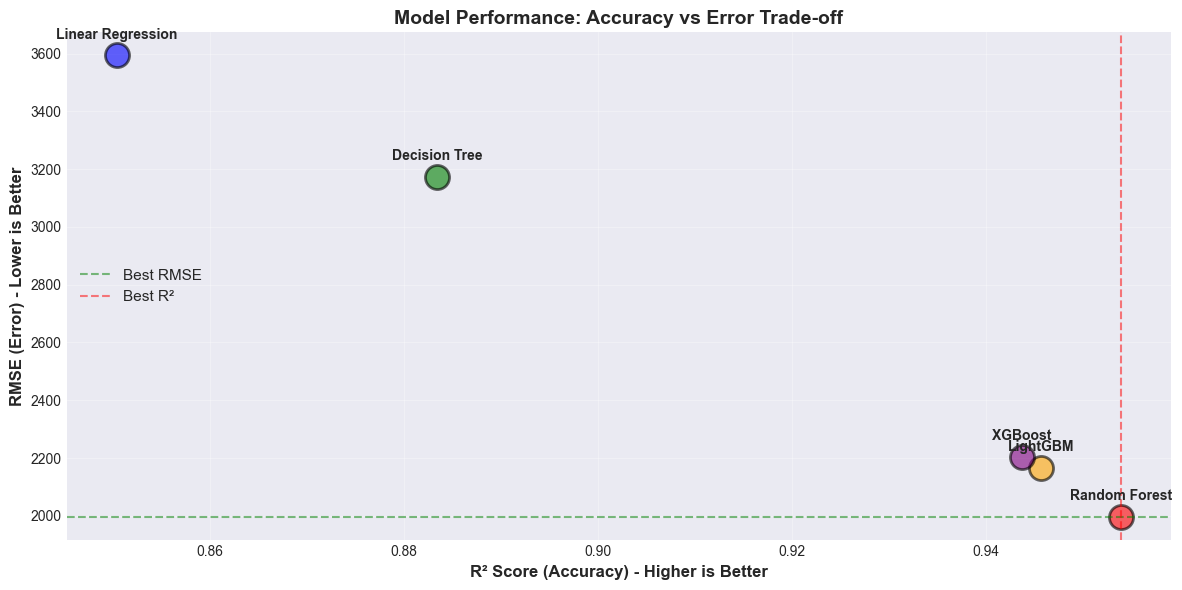


Ideal Model: High R² (top-right) and Low RMSE (bottom-right)


In [102]:
# Accuracy vs Error Scatter Plot
plt.figure(figsize=(12, 6))

# Plot R2 (accuracy) vs RMSE (error) for each model
colors_map = {'Linear Regression': 'blue', 'Decision Tree': 'green', 
              'Random Forest': 'red', 'XGBoost': 'purple', 'LightGBM': 'orange'}

for model_name in results_df.index:
    r2 = results_df.loc[model_name, 'R2']
    rmse = results_df.loc[model_name, 'RMSE']
    color = colors_map.get(model_name, 'gray')
    
    plt.scatter(r2, rmse, s=300, alpha=0.6, c=color, edgecolor='black', linewidth=2)
    plt.annotate(model_name, (r2, rmse), fontsize=10, ha='center', va='bottom', 
                fontweight='bold', xytext=(0, 10), textcoords='offset points')

plt.xlabel('R² Score (Accuracy) - Higher is Better', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (Error) - Lower is Better', fontsize=12, fontweight='bold')
plt.title('Model Performance: Accuracy vs Error Trade-off', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=results_df['RMSE'].min(), color='green', linestyle='--', alpha=0.5, label='Best RMSE')
plt.axvline(x=results_df['R2'].max(), color='red', linestyle='--', alpha=0.5, label='Best R²')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\nIdeal Model: High R² (top-right) and Low RMSE (bottom-right)")

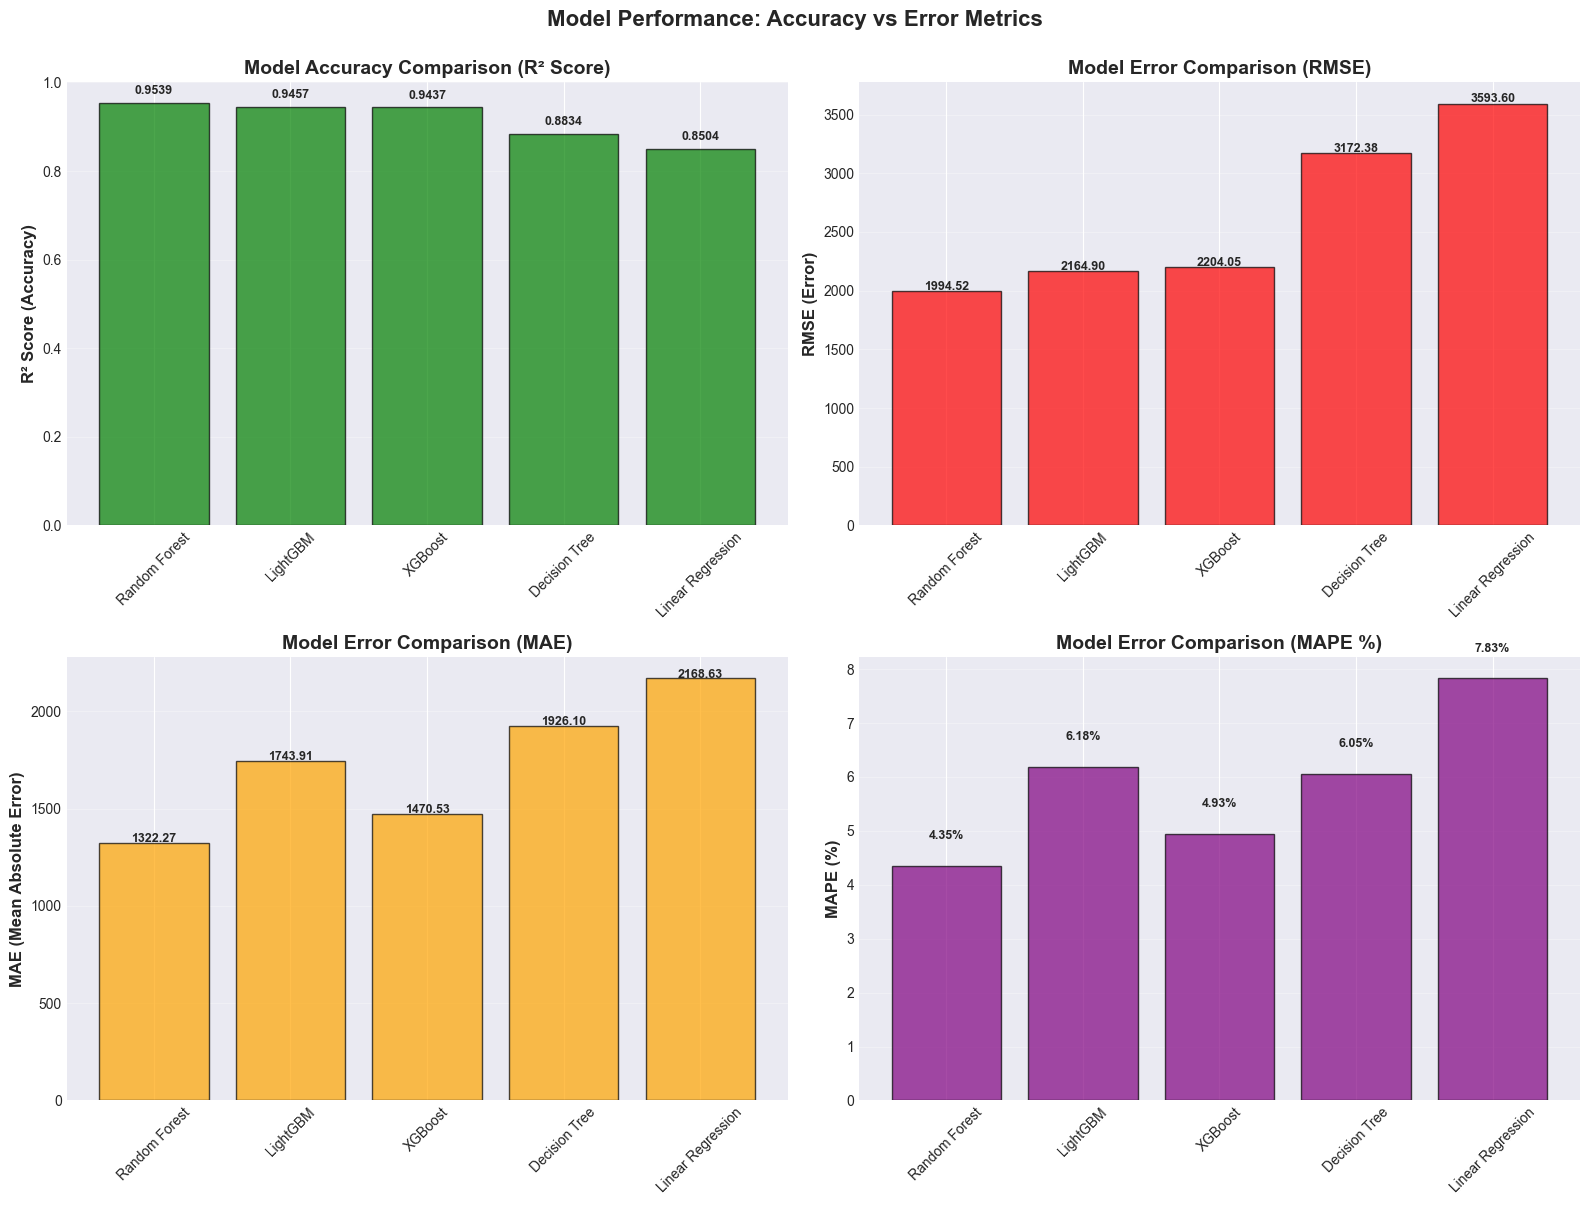


Best Accuracy (Highest R²): Random Forest = 0.9539
Lowest Error (RMSE): Random Forest = 1994.52
Lowest Error (MAE): Random Forest = 1322.27
Lowest Error (MAPE): Random Forest = 4.35%


In [103]:
# Visualize Error and Accuracy Metrics for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R2 Score (Accuracy) - Higher is better
axes[0, 0].bar(results_df.index, results_df['R2'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('R² Score (Accuracy)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Accuracy Comparison (R² Score)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (model, r2) in enumerate(zip(results_df.index, results_df['R2'])):
    axes[0, 0].text(i, r2 + 0.02, f'{r2:.4f}', ha='center', fontsize=9, fontweight='bold')

# 2. RMSE (Error) - Lower is better
axes[0, 1].bar(results_df.index, results_df['RMSE'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('RMSE (Error)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model Error Comparison (RMSE)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, (model, rmse) in enumerate(zip(results_df.index, results_df['RMSE'])):
    axes[0, 1].text(i, rmse + 10, f'{rmse:.2f}', ha='center', fontsize=9, fontweight='bold')

# 3. MAE (Error) - Lower is better
axes[1, 0].bar(results_df.index, results_df['MAE'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('MAE (Mean Absolute Error)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Model Error Comparison (MAE)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, (model, mae) in enumerate(zip(results_df.index, results_df['MAE'])):
    axes[1, 0].text(i, mae + 5, f'{mae:.2f}', ha='center', fontsize=9, fontweight='bold')

# 4. MAPE (Error %) - Lower is better
axes[1, 1].bar(results_df.index, results_df['MAPE'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Model Error Comparison (MAPE %)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, (model, mape) in enumerate(zip(results_df.index, results_df['MAPE'])):
    axes[1, 1].text(i, mape + 0.5, f'{mape:.2f}%', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Model Performance: Accuracy vs Error Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nBest Accuracy (Highest R²): {best_model_name} = {results_df.loc[best_model_name, 'R2']:.4f}")
print(f"Lowest Error (RMSE): {results_df['RMSE'].idxmin()} = {results_df['RMSE'].min():.2f}")
print(f"Lowest Error (MAE): {results_df['MAE'].idxmin()} = {results_df['MAE'].min():.2f}")
print(f"Lowest Error (MAPE): {results_df['MAPE'].idxmin()} = {results_df['MAPE'].min():.2f}%")

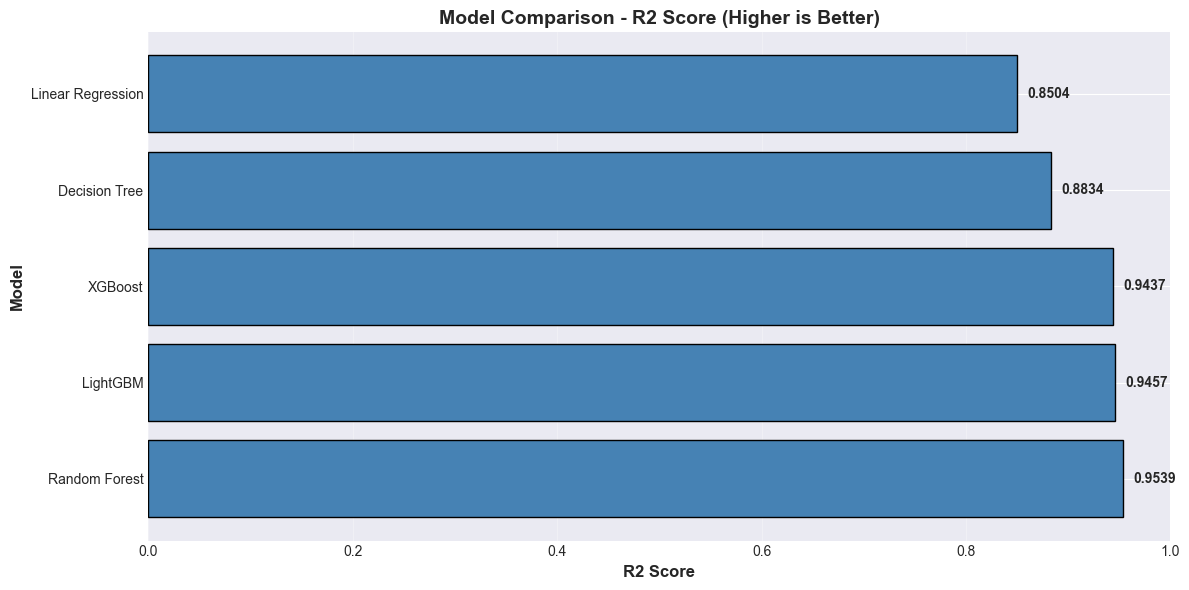

In [104]:
# Visualize model comparison - R2 Score
plt.figure(figsize=(12, 6))
plt.barh(results_df.index, results_df['R2'], color='steelblue', edgecolor='black')
plt.xlabel('R2 Score', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Model Comparison - R2 Score (Higher is Better)', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for idx, (model, r2) in enumerate(zip(results_df.index, results_df['R2'])):
    plt.text(r2 + 0.01, idx, f'{r2:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

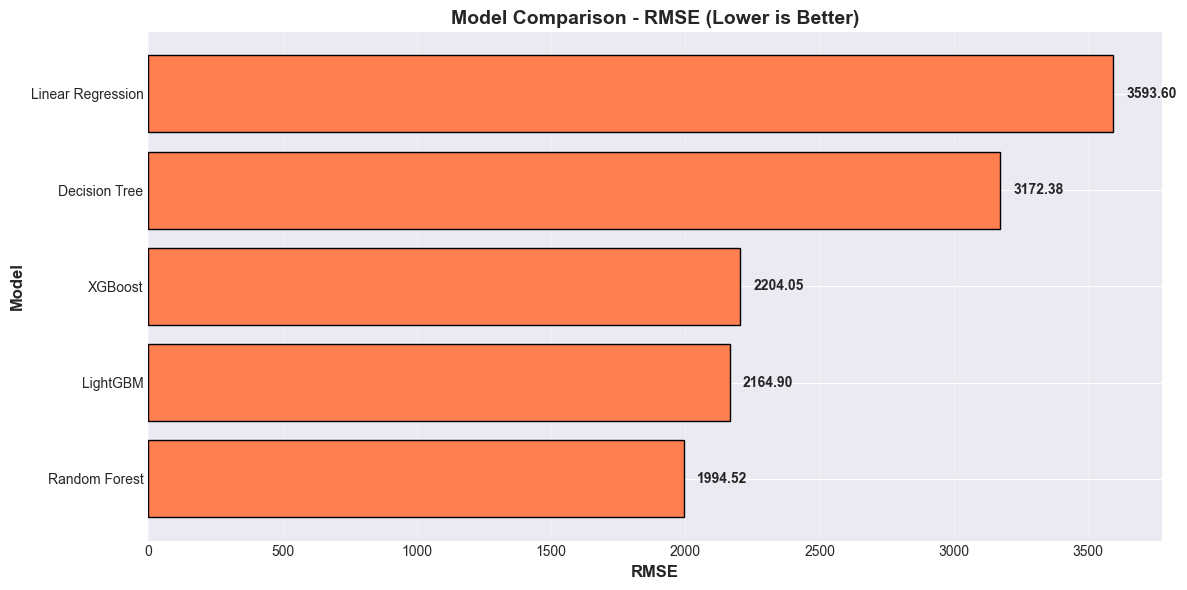

In [105]:
# Visualize model comparison - RMSE
plt.figure(figsize=(12, 6))
results_df_sorted_rmse = results_df.sort_values('RMSE', ascending=True)
plt.barh(results_df_sorted_rmse.index, results_df_sorted_rmse['RMSE'], color='coral', edgecolor='black')
plt.xlabel('RMSE', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Model Comparison - RMSE (Lower is Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for idx, (model, rmse) in enumerate(zip(results_df_sorted_rmse.index, results_df_sorted_rmse['RMSE'])):
    plt.text(rmse + 50, idx, f'{rmse:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

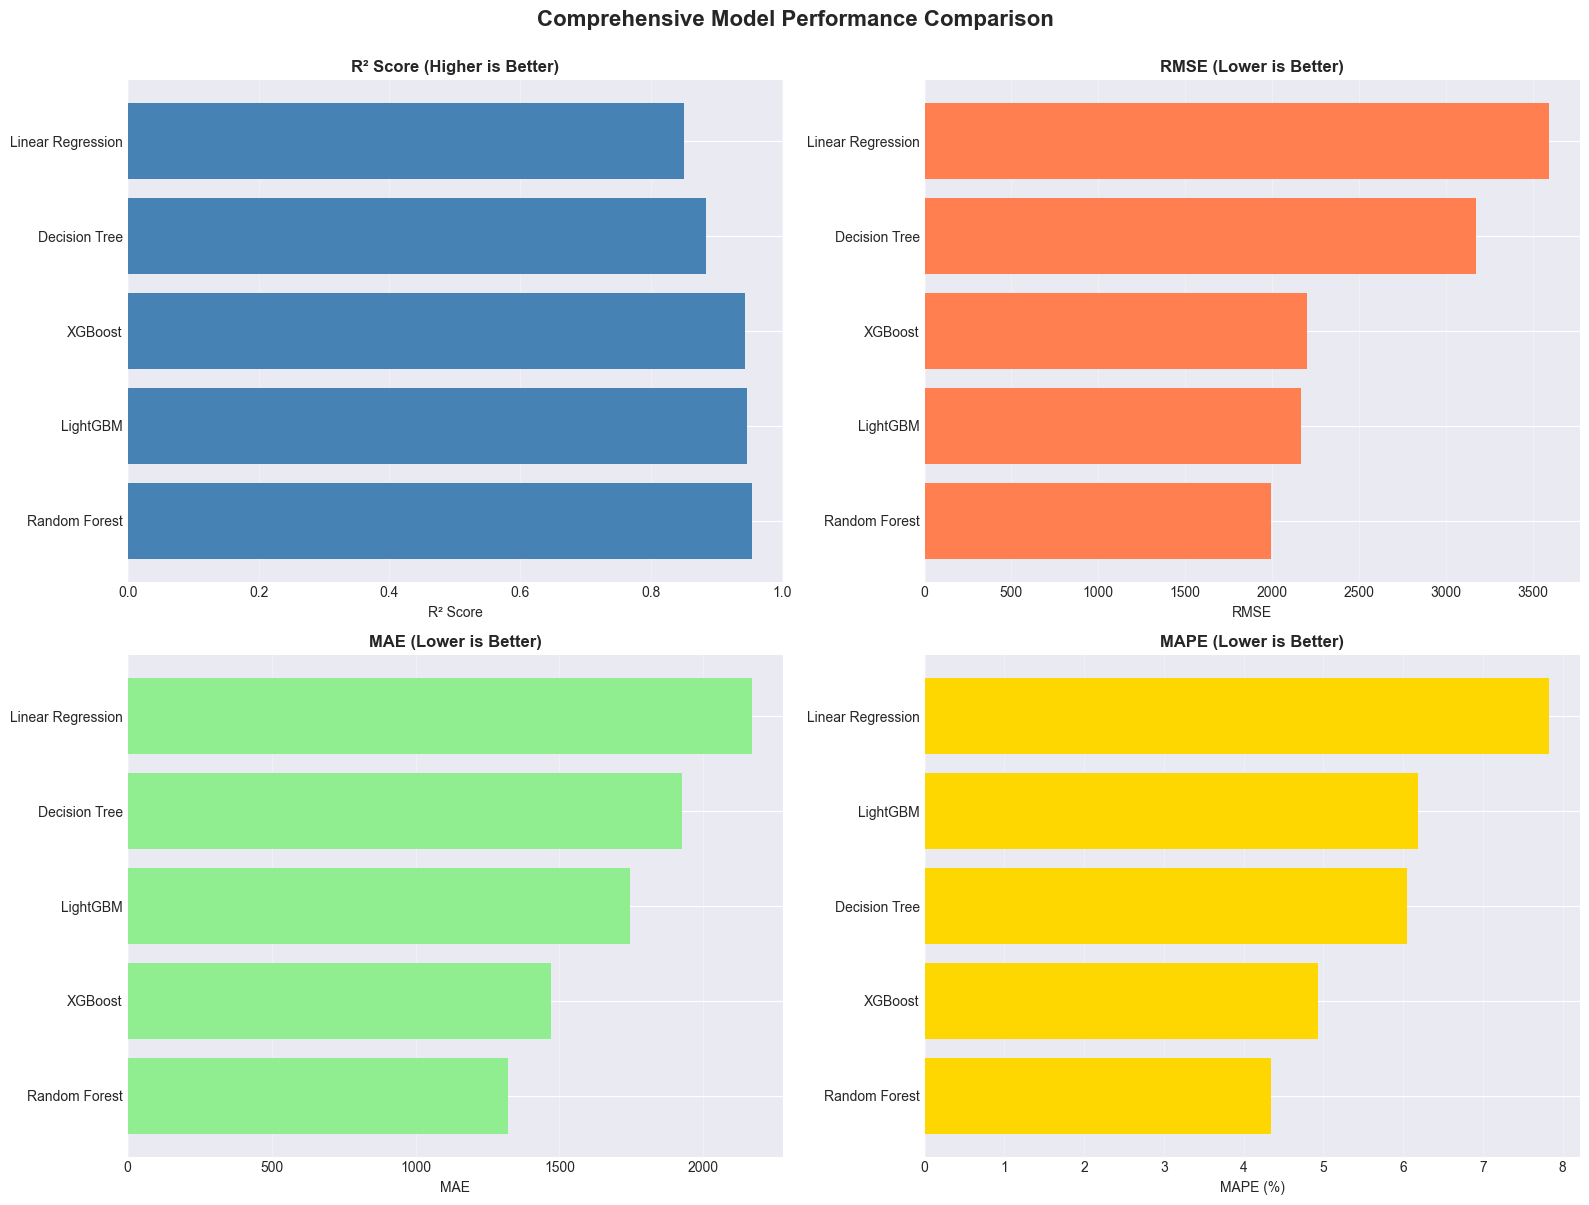

In [106]:
# Multi-metric comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score
axes[0, 0].barh(results_df.index, results_df['R2'], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('R² Score (Higher is Better)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# RMSE
results_df_rmse = results_df.sort_values('RMSE')
axes[0, 1].barh(results_df_rmse.index, results_df_rmse['RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('RMSE (Lower is Better)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# MAE
results_df_mae = results_df.sort_values('MAE')
axes[1, 0].barh(results_df_mae.index, results_df_mae['MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('MAE (Lower is Better)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# MAPE
results_df_mape = results_df.sort_values('MAPE')
axes[1, 1].barh(results_df_mape.index, results_df_mape['MAPE'], color='gold')
axes[1, 1].set_xlabel('MAPE (%)')
axes[1, 1].set_title('MAPE (Lower is Better)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

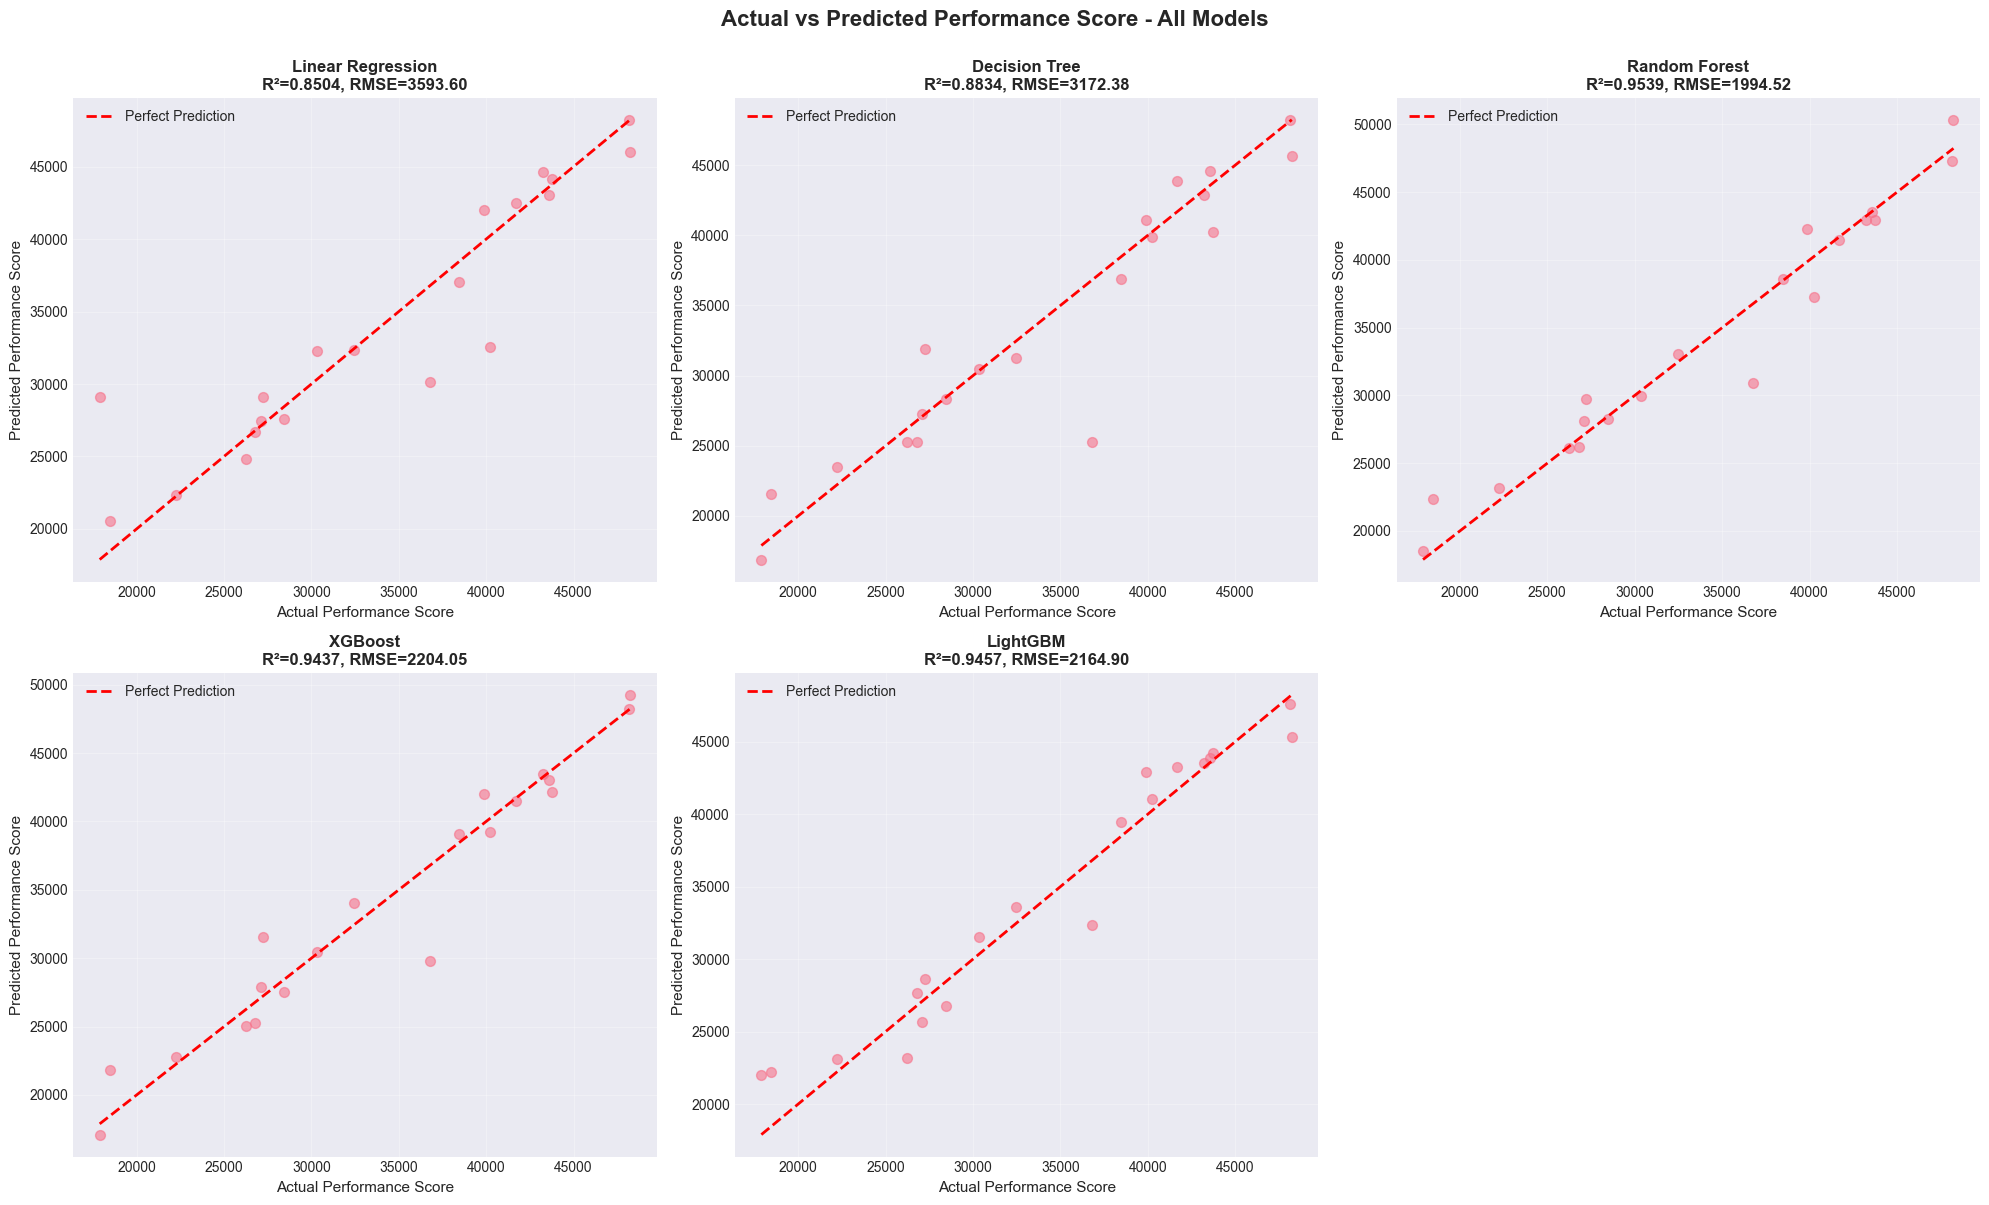

In [107]:
# Actual vs Predicted plots for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Performance Score', fontsize=11)
    axes[idx].set_ylabel('Predicted Performance Score', fontsize=11)
    axes[idx].set_title(f'{name}\nR²={results[name]["R2"]:.4f}, RMSE={results[name]["RMSE"]:.2f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide the last subplot if odd number of models
if len(predictions) < 6:
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Performance Score - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

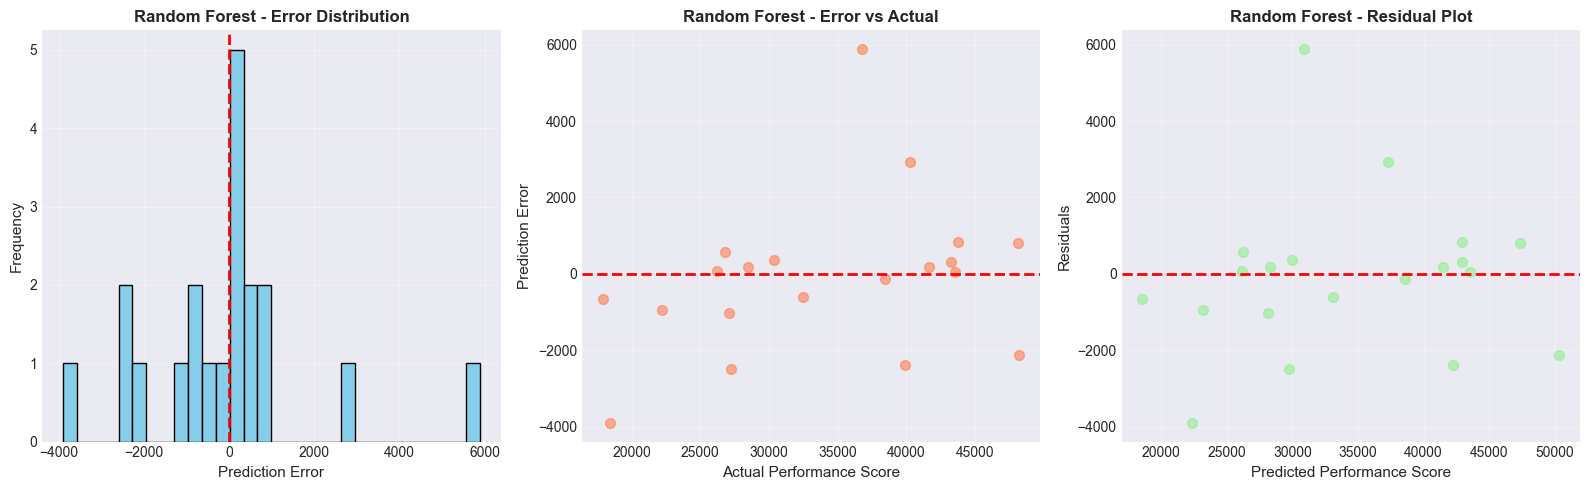


Random Forest - Error Statistics:
   - Mean Error: -103.83
   - Std Error: 2043.56
   - Min Error: -3900.32
   - Max Error: 5886.56


In [108]:
# Prediction error analysis for best model
best_predictions = predictions[best_model_name]
errors = y_test - best_predictions

plt.figure(figsize=(16, 5))

# Error distribution
plt.subplot(1, 3, 1)
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Error', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'{best_model_name} - Error Distribution', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Error vs Actual
plt.subplot(1, 3, 2)
plt.scatter(y_test, errors, alpha=0.6, s=50, color='coral')
plt.xlabel('Actual Performance Score', fontsize=11)
plt.ylabel('Prediction Error', fontsize=11)
plt.title(f'{best_model_name} - Error vs Actual', fontsize=12, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Residuals
plt.subplot(1, 3, 3)
plt.scatter(best_predictions, errors, alpha=0.6, s=50, color='lightgreen')
plt.xlabel('Predicted Performance Score', fontsize=11)
plt.ylabel('Residuals', fontsize=11)
plt.title(f'{best_model_name} - Residual Plot', fontsize=12, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{best_model_name} - Error Statistics:")
print(f"   - Mean Error: {errors.mean():.2f}")
print(f"   - Std Error: {errors.std():.2f}")
print(f"   - Min Error: {errors.min():.2f}")
print(f"   - Max Error: {errors.max():.2f}")

## Step 9: Feature Importance Analysis

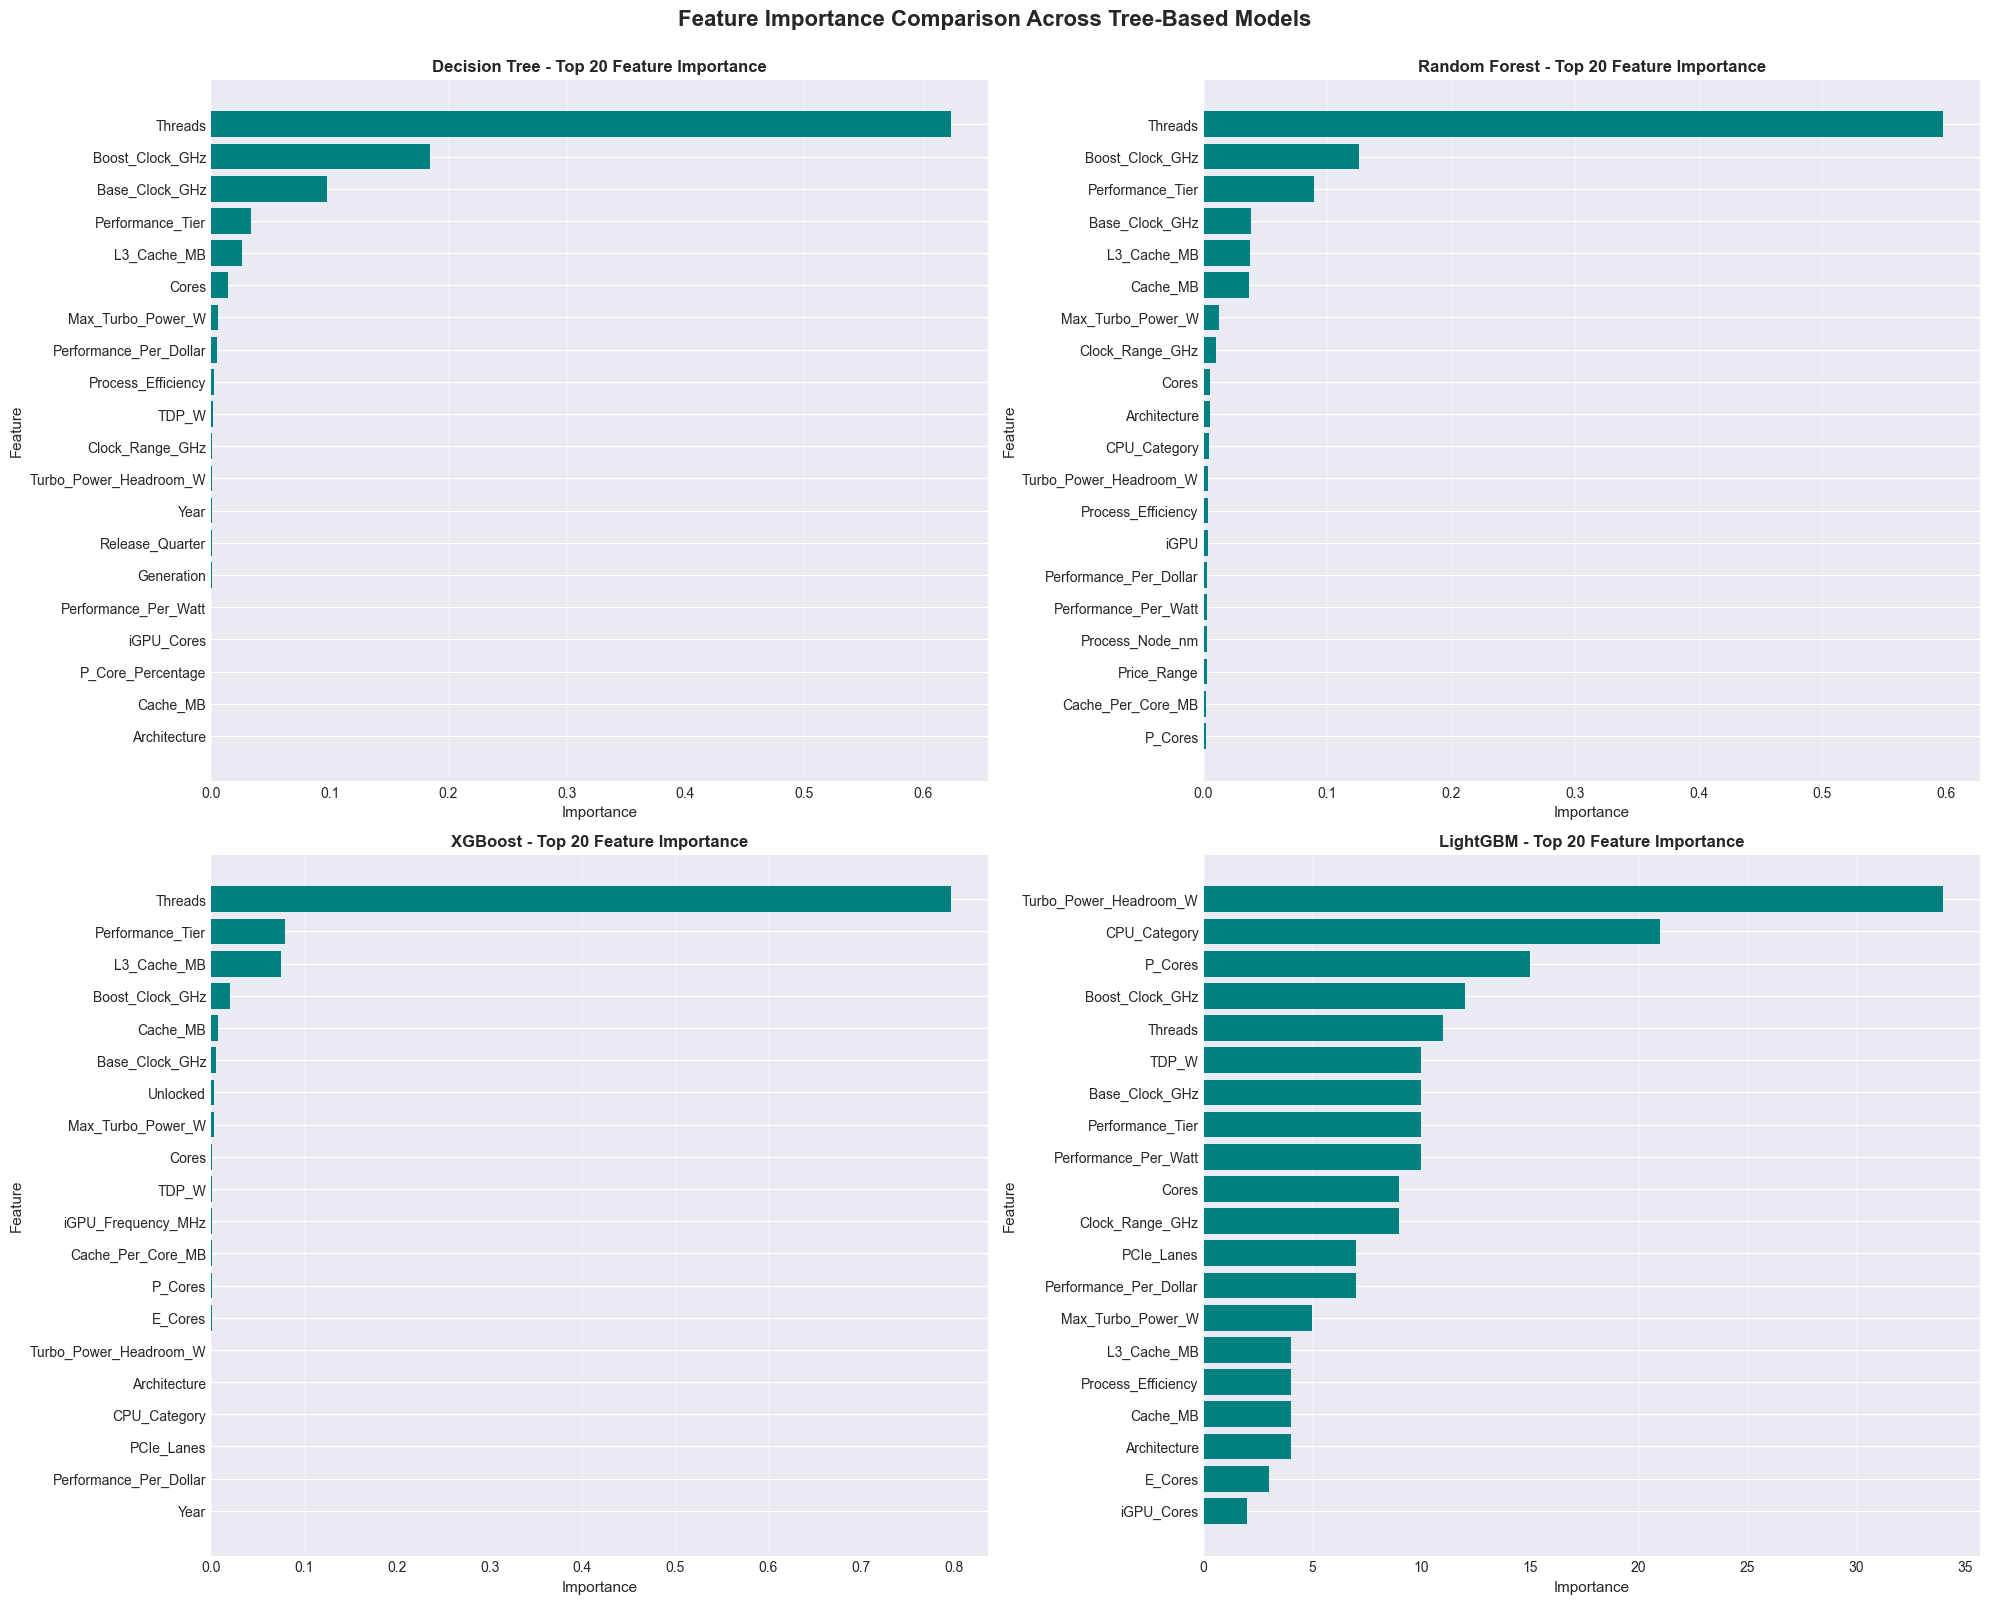

In [109]:
# Feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, model_name in enumerate(tree_models):
    model = models[model_name]
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Create DataFrame and sort
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(20)
        
        # Plot
        axes[idx].barh(importance_df['Feature'], importance_df['Importance'], color='teal')
        axes[idx].set_xlabel('Importance', fontsize=11)
        axes[idx].set_ylabel('Feature', fontsize=11)
        axes[idx].set_title(f'{model_name} - Top 20 Feature Importance', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='x')
        axes[idx].invert_yaxis()

plt.suptitle('Feature Importance Comparison Across Tree-Based Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


TOP 20 MOST IMPORTANT FEATURES (Random Forest)
               Feature  Importance
               Threads    0.597399
       Boost_Clock_GHz    0.125645
      Performance_Tier    0.088902
        Base_Clock_GHz    0.038212
           L3_Cache_MB    0.037270
              Cache_MB    0.037048
     Max_Turbo_Power_W    0.012581
       Clock_Range_GHz    0.010451
                 Cores    0.005402
          Architecture    0.005215
          CPU_Category    0.004355
Turbo_Power_Headroom_W    0.003883
    Process_Efficiency    0.003807
                  iGPU    0.003627
Performance_Per_Dollar    0.003021
  Performance_Per_Watt    0.002891
       Process_Node_nm    0.002660
           Price_Range    0.002570
     Cache_Per_Core_MB    0.002321
               P_Cores    0.002077


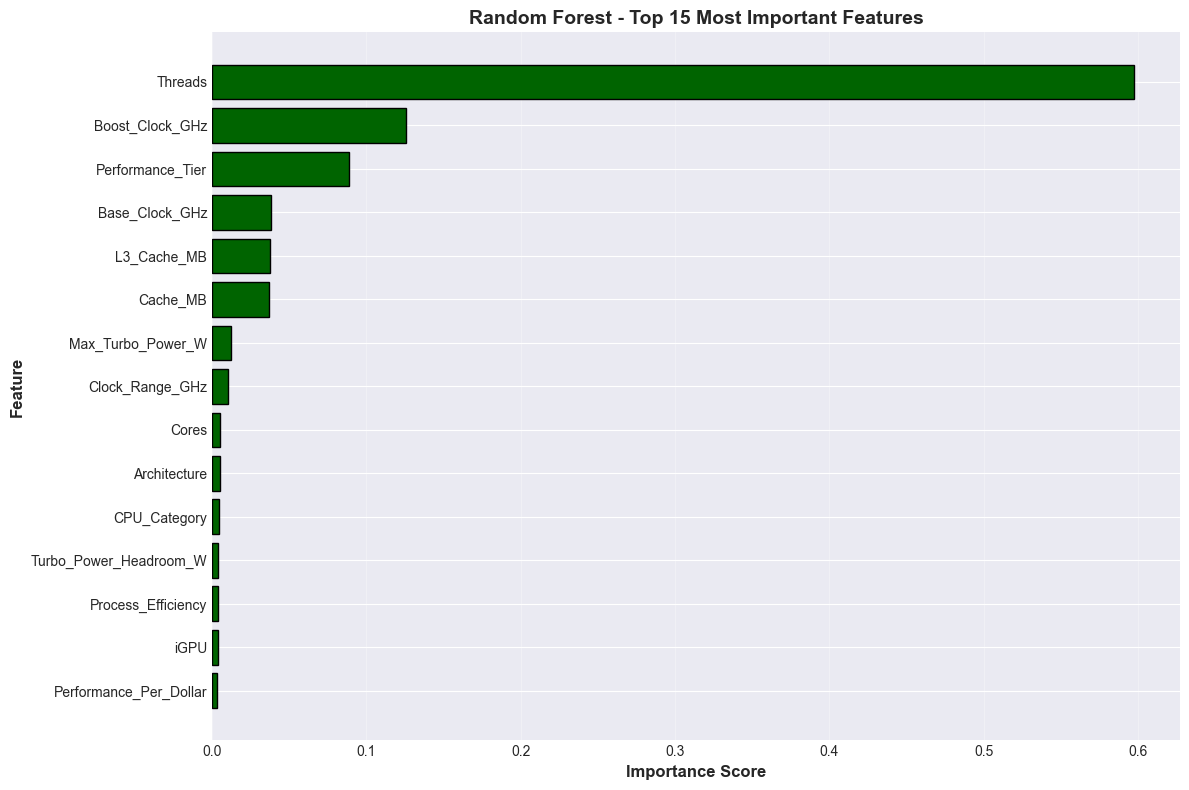

In [110]:
# Top 10 most important features from best model
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTOP 20 MOST IMPORTANT FEATURES ({best_model_name})")
    print("="*70)
    print(importance_df.head(20).to_string(index=False))
    
    # Visualize top 15
    plt.figure(figsize=(12, 8))
    top_15 = importance_df.head(15)
    plt.barh(top_15['Feature'], top_15['Importance'], color='darkgreen', edgecolor='black')
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'{best_model_name} - Top 15 Most Important Features', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not support feature importance")

## Step 10: Hyperparameter Tuning (GridSearchCV)

In [111]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nTraining with GridSearchCV (this may take a few minutes)...")
grid_search.fit(X_train_scaled, y_train)

print("\nGridSearchCV completed!")
print(f"\nBEST PARAMETERS:")
print("="*70)
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\nBEST CROSS-VALIDATION SCORE: {grid_search.best_score_:.4f}")


Training with GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

GridSearchCV completed!

BEST PARAMETERS:
   - max_depth: 20
   - min_samples_leaf: 1
   - min_samples_split: 2
   - n_estimators: 300

BEST CROSS-VALIDATION SCORE: 0.9538

GridSearchCV completed!

BEST PARAMETERS:
   - max_depth: 20
   - min_samples_leaf: 1
   - min_samples_split: 2
   - n_estimators: 300

BEST CROSS-VALIDATION SCORE: 0.9538


In [112]:
# Evaluate tuned model
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Calculate metrics for tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned) * 100

print("\nTUNED RANDOM FOREST PERFORMANCE")
print("="*70)
print(f"   - R2 Score: {r2_tuned:.4f}")
print(f"   - RMSE: {rmse_tuned:.2f}")
print(f"   - MAE: {mae_tuned:.2f}")
print(f"   - MAPE: {mape_tuned:.2f}%")

# Compare with original Random Forest
print(f"\nIMPROVEMENT OVER ORIGINAL RANDOM FOREST:")
print("="*70)
original_r2 = results['Random Forest']['R2']
original_rmse = results['Random Forest']['RMSE']

print(f"   - R2 Score: {original_r2:.4f} -> {r2_tuned:.4f} ({r2_tuned - original_r2:+.4f})")
print(f"   - RMSE: {original_rmse:.2f} -> {rmse_tuned:.2f} ({rmse_tuned - original_rmse:+.2f})")

if r2_tuned > original_r2:
    print(f"\nTuned model is BETTER!")
else:
    print(f"\nOriginal model performed similarly or better")


TUNED RANDOM FOREST PERFORMANCE
   - R2 Score: 0.9532
   - RMSE: 2010.72
   - MAE: 1338.86
   - MAPE: 4.41%

IMPROVEMENT OVER ORIGINAL RANDOM FOREST:
   - R2 Score: 0.9539 -> 0.9532 (-0.0008)
   - RMSE: 1994.52 -> 2010.72 (+16.19)

Original model performed similarly or better


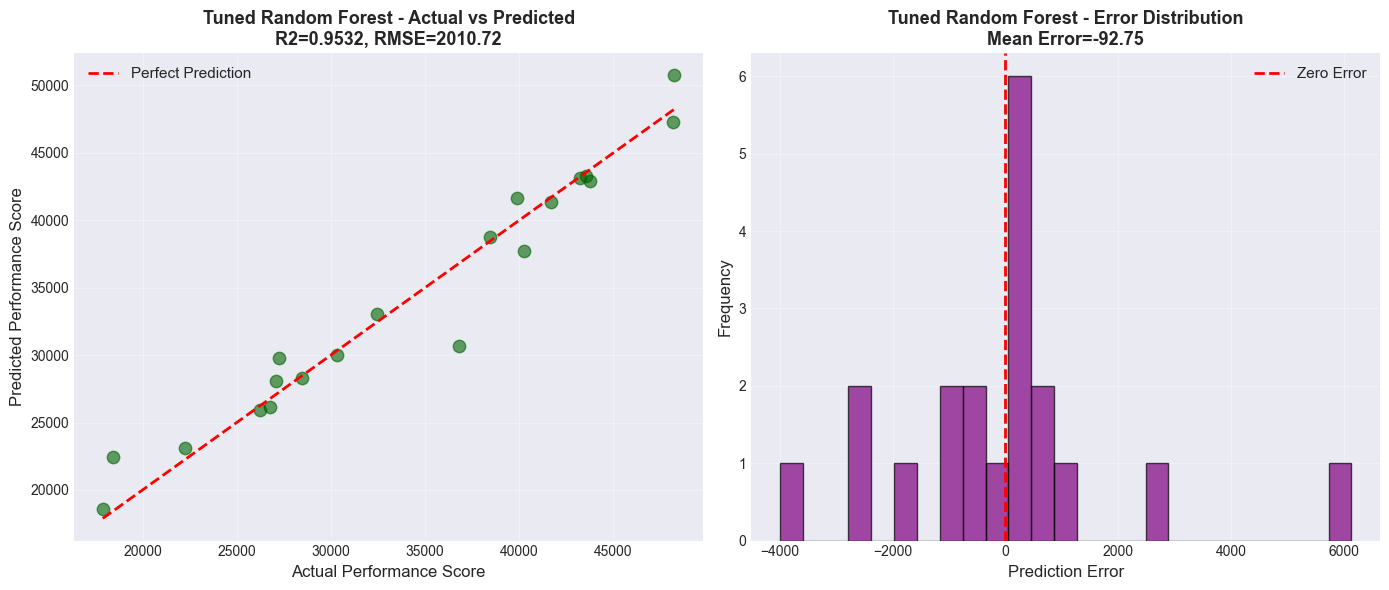

In [113]:
# Visualize tuned model performance
plt.figure(figsize=(14, 6))

# Actual vs Predicted for tuned model
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_tuned, alpha=0.6, s=80, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Performance Score', fontsize=12)
plt.ylabel('Predicted Performance Score', fontsize=12)
plt.title(f'Tuned Random Forest - Actual vs Predicted\nR2={r2_tuned:.4f}, RMSE={rmse_tuned:.2f}', 
         fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Error distribution for tuned model
errors_tuned = y_test - y_pred_tuned
plt.subplot(1, 2, 2)
plt.hist(errors_tuned, bins=25, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Tuned Random Forest - Error Distribution\nMean Error={errors_tuned.mean():.2f}', 
         fontsize=13, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 11: Advanced Visualizations & Insights

In [114]:
# Create prediction comparison DataFrame
comparison_df = pd.DataFrame({
    'CPU_Index': range(len(y_test)),
    'Actual': y_test.values,
    'Predicted': best_predictions,
    'Error': errors.values,
    'Error_Percentage': (errors.values / y_test.values * 100)
})

# Sort by absolute error
comparison_df['Abs_Error'] = comparison_df['Error'].abs()
comparison_df = comparison_df.sort_values('Abs_Error', ascending=False)

print("\nBEST PREDICTIONS (Lowest Error)")
print("="*70)
best_preds = comparison_df.nsmallest(10, 'Abs_Error')
print(best_preds[['CPU_Index', 'Actual', 'Predicted', 'Error', 'Error_Percentage']].to_string(index=False))

print("\n\nWORST PREDICTIONS (Highest Error)")
print("="*70)
worst_preds = comparison_df.nlargest(10, 'Abs_Error')
print(worst_preds[['CPU_Index', 'Actual', 'Predicted', 'Error', 'Error_Percentage']].to_string(index=False))


BEST PREDICTIONS (Lowest Error)
 CPU_Index  Actual  Predicted   Error  Error_Percentage
        15   43567   43527.35   39.65          0.091009
        19   26234   26146.77   87.23          0.332507
        13   38456   38593.09 -137.09         -0.356485
        12   28456   28286.21  169.79          0.596676
        17   41678   41488.84  189.16          0.453861
         8   43234   42931.52  302.48          0.699635
         7   30340   29984.60  355.40          1.171391
        18   26789   26225.06  563.94          2.105118
         4   32456   33068.77 -612.77         -1.888002
        14   17890   18552.70 -662.70         -3.704304


WORST PREDICTIONS (Highest Error)
 CPU_Index  Actual  Predicted    Error  Error_Percentage
         0   36789   30902.44  5886.56         16.000870
         1   18456   22356.32 -3900.32        -21.133073
        10   40234   37294.61  2939.39          7.305736
         2   27234   29712.64 -2478.64         -9.101270
         5   39876   42264.16 


CROSS-VALIDATION ANALYSIS (5-Fold CV)

Linear Regression:
   - Mean R2 Score: 0.9482 (+/-0.0204)
   - Min-Max Range: 0.9308 - 0.9739

Decision Tree:
   - Mean R2 Score: 0.8127 (+/-0.1074)
   - Min-Max Range: 0.6751 - 0.9299

Random Forest:
   - Mean R2 Score: 0.9515 (+/-0.0154)
   - Min-Max Range: 0.9269 - 0.9676

Random Forest:
   - Mean R2 Score: 0.9515 (+/-0.0154)
   - Min-Max Range: 0.9269 - 0.9676

XGBoost:
   - Mean R2 Score: 0.9489 (+/-0.0224)
   - Min-Max Range: 0.9176 - 0.9782

LightGBM:
   - Mean R2 Score: 0.8923 (+/-0.0461)
   - Min-Max Range: 0.8191 - 0.9620

XGBoost:
   - Mean R2 Score: 0.9489 (+/-0.0224)
   - Min-Max Range: 0.9176 - 0.9782

LightGBM:
   - Mean R2 Score: 0.8923 (+/-0.0461)
   - Min-Max Range: 0.8191 - 0.9620


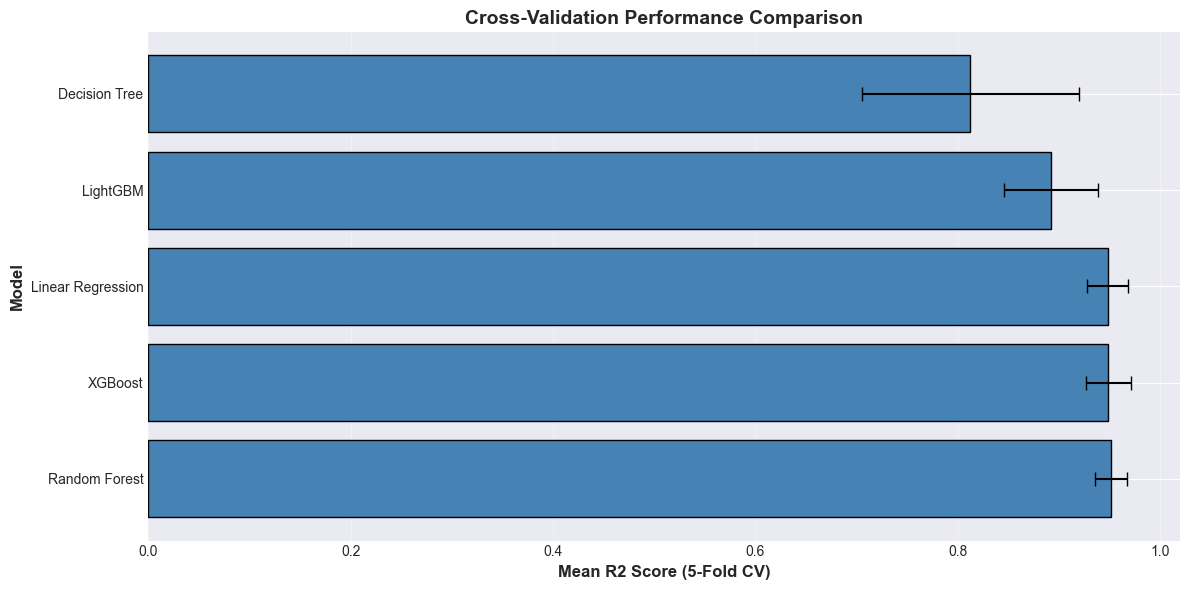

In [115]:
# Cross-validation for all models
print("\nCROSS-VALIDATION ANALYSIS (5-Fold CV)")
print("="*70)

cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results[name] = {
        'Mean': cv_scores.mean(),
        'Std': cv_scores.std(),
        'Min': cv_scores.min(),
        'Max': cv_scores.max()
    }
    print(f"\n{name}:")
    print(f"   - Mean R2 Score: {cv_scores.mean():.4f} (+/-{cv_scores.std():.4f})")
    print(f"   - Min-Max Range: {cv_scores.min():.4f} - {cv_scores.max():.4f}")

# Visualize CV results
cv_df = pd.DataFrame(cv_results).T.sort_values('Mean', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(cv_df.index, cv_df['Mean'], xerr=cv_df['Std'], 
         color='steelblue', edgecolor='black', capsize=5)
plt.xlabel('Mean R2 Score (5-Fold CV)', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Cross-Validation Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [116]:
# Sample prediction on new data (using test set examples)
print("\nSAMPLE PREDICTIONS ON TEST DATA")
print("="*70)

# Get a few random samples from test set
sample_indices = np.random.choice(len(X_test), size=5, replace=False)
X_sample = X_test_scaled[sample_indices]
y_actual = y_test.iloc[sample_indices]

# Predict using best model
best_model_obj = models[best_model_name]
y_sample_pred = best_model_obj.predict(X_sample)

print(f"\nUsing {best_model_name} for predictions:\n")
for i, (actual, predicted) in enumerate(zip(y_actual, y_sample_pred)):
    error = actual - predicted
    error_pct = (error / actual) * 100
    print(f"Sample {i+1}:")
    print(f"   - Actual: {actual:.2f}")
    print(f"   - Predicted: {predicted:.2f}")
    print(f"   - Error: {error:.2f} ({error_pct:.2f}%)")
    print()


SAMPLE PREDICTIONS ON TEST DATA

Using Random Forest for predictions:

Sample 1:
   - Actual: 26234.00
   - Predicted: 26146.77
   - Error: 87.23 (0.33%)

Sample 2:
   - Actual: 27100.00
   - Predicted: 28116.70
   - Error: -1016.70 (-3.75%)

Sample 3:
   - Actual: 39876.00
   - Predicted: 42264.16
   - Error: -2388.16 (-5.99%)

Sample 4:
   - Actual: 28456.00
   - Predicted: 28286.21
   - Error: 169.79 (0.60%)

Sample 5:
   - Actual: 17890.00
   - Predicted: 18552.70
   - Error: -662.70 (-3.70%)



## Step 12: Model Saving & Deployment Preparation

In [117]:
# Save the best model and preprocessing objects
import pickle
import joblib
from datetime import datetime

# Create models directory if not exists
import os
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory")

# Save best model
best_model_obj = models[best_model_name]
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Using joblib (recommended for scikit-learn models)
model_filename = f'models/best_model_{best_model_name.replace(" ", "_")}_{timestamp}.joblib'
joblib.dump(best_model_obj, model_filename)
print(f"\nBest model saved: {model_filename}")

# Save scaler
scaler_filename = f'models/scaler_{timestamp}.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved: {scaler_filename}")

# Save label encoders
encoders_filename = f'models/label_encoders_{timestamp}.pkl'
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"Label encoders saved: {encoders_filename}")

# Save feature names
feature_names_filename = f'models/feature_names_{timestamp}.pkl'
with open(feature_names_filename, 'wb') as f:
    pickle.dump(list(X_train.columns), f)
print(f"Feature names saved: {feature_names_filename}")

print(f"\nAll artifacts saved successfully!")
print(f"   Model: {best_model_name}")
print(f"   R2 Score: {results[best_model_name]['R2']:.4f}")
print(f"   RMSE: {results[best_model_name]['RMSE']:.2f}")

Created 'models' directory

Best model saved: models/best_model_Random_Forest_20251202_203437.joblib
Scaler saved: models/scaler_20251202_203437.joblib
Label encoders saved: models/label_encoders_20251202_203437.pkl
Feature names saved: models/feature_names_20251202_203437.pkl

All artifacts saved successfully!
   Model: Random Forest
   R2 Score: 0.9539
   RMSE: 1994.52


In [118]:
# Test loading the saved model
print("\nTESTING MODEL LOADING")
print("="*70)

# Load the model
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Make a test prediction
test_sample = X_test.iloc[0:1]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_prediction = loaded_model.predict(test_sample_scaled)

print(f"\nModel loaded successfully!")
print(f"\nTest Prediction:")
print(f"   - Input (first test sample): {test_sample.index[0]}")
print(f"   - Predicted Performance Score: {test_prediction[0]:.2f}")
print(f"   - Actual Performance Score: {y_test.iloc[0]:.2f}")
print(f"   - Difference: {abs(test_prediction[0] - y_test.iloc[0]):.2f}")

print(f"\nModel is ready for deployment!")


TESTING MODEL LOADING

Model loaded successfully!

Test Prediction:
   - Input (first test sample): 80
   - Predicted Performance Score: 30902.44
   - Actual Performance Score: 36789.00
   - Difference: 5886.56

Model is ready for deployment!


## Final Summary & Conclusions

## ROC-like Curves for Regression Models

Since ROC curves are designed for classification, we'll create equivalent visualizations for regression:
- **Cumulative Gain Curve**: Shows model performance across prediction range
- **Prediction Error Probability Curve**: Distribution of errors
- **Sorted Predictions Curve**: Actual vs Predicted in sorted order

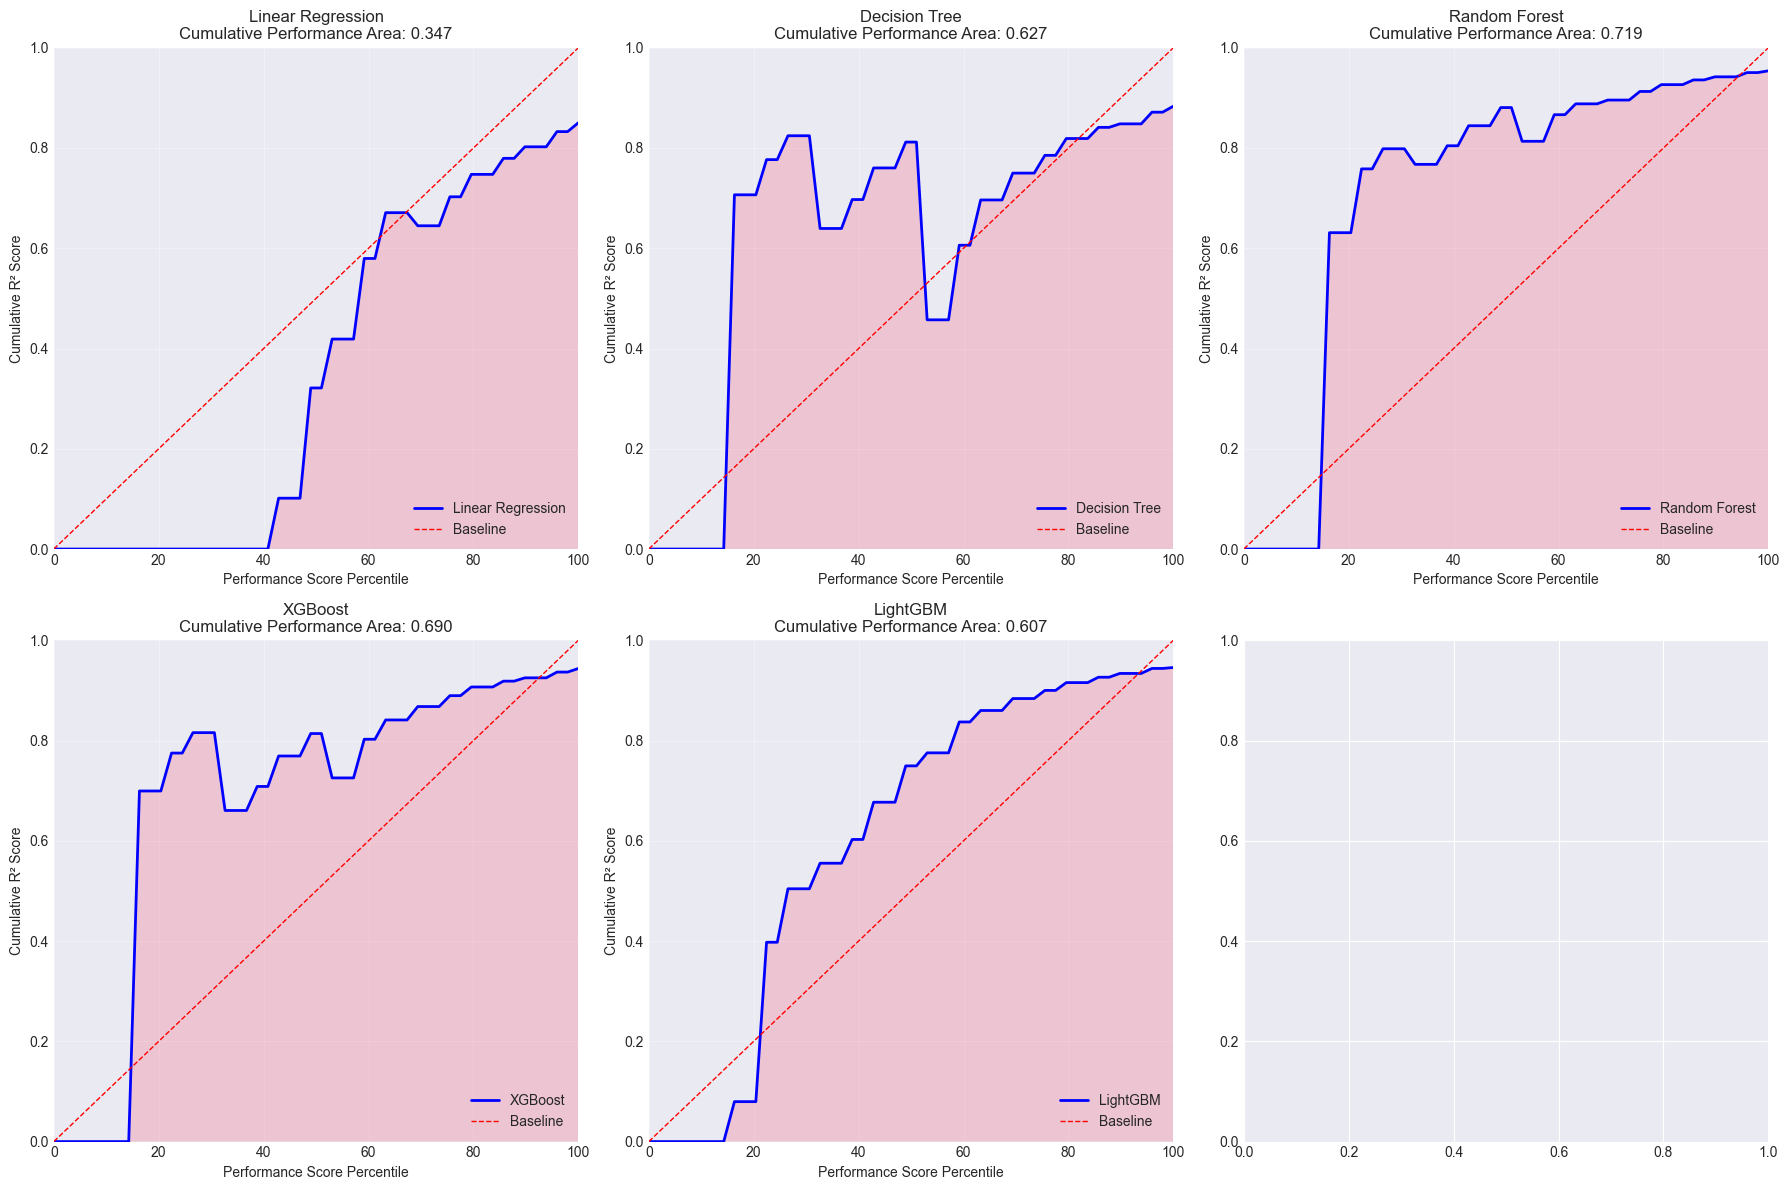

ROC-style curves generated for all models!


In [119]:
# ROC-Curve Style Analysis for All Models
from scipy import stats

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, metrics) in enumerate(results.items()):
    # Get predictions
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    # Calculate percentile-based performance (similar to ROC)
    sorted_indices = np.argsort(y_test)
    y_test_sorted = y_test.iloc[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    # Calculate cumulative accuracy at different thresholds
    percentiles = np.linspace(0, 100, 50)
    cumulative_r2 = []
    
    for p in percentiles:
        threshold = np.percentile(y_test, p)
        mask = y_test <= threshold
        if mask.sum() > 1:
            r2 = r2_score(y_test[mask], model.predict(X_test_scaled)[mask])
            cumulative_r2.append(max(r2, 0))
        else:
            cumulative_r2.append(0)
    
    # Plot
    axes[idx].plot(percentiles, cumulative_r2, 'b-', linewidth=2, label=f'{model_name}')
    axes[idx].plot([0, 100], [0, 1], 'r--', linewidth=1, label='Baseline')
    axes[idx].fill_between(percentiles, cumulative_r2, alpha=0.3)
    
    # Calculate AUC-like metric
    auc_metric = np.trapz(cumulative_r2, percentiles) / 100
    
    axes[idx].set_xlabel('Performance Score Percentile')
    axes[idx].set_ylabel('Cumulative R² Score')
    axes[idx].set_title(f'{model_name}\nCumulative Performance Area: {auc_metric:.3f}')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 100])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("ROC-style curves generated for all models!")


GENERATING INDIVIDUAL ROC-STYLE CURVES FOR EACH MODEL

Generating curve for Linear Regression...


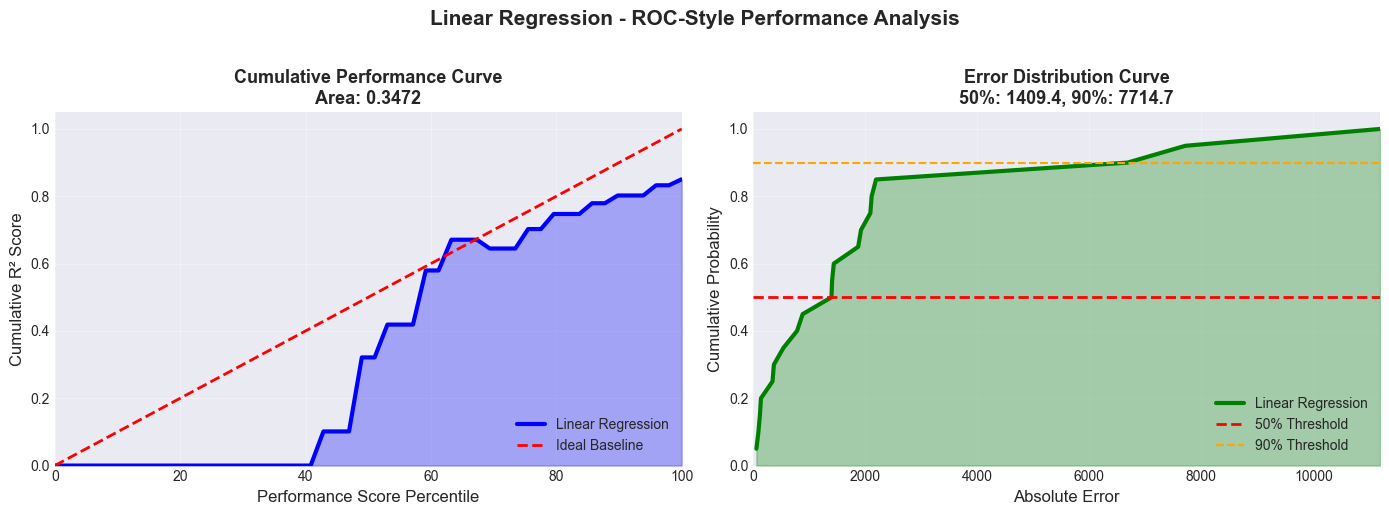


Generating curve for Decision Tree...


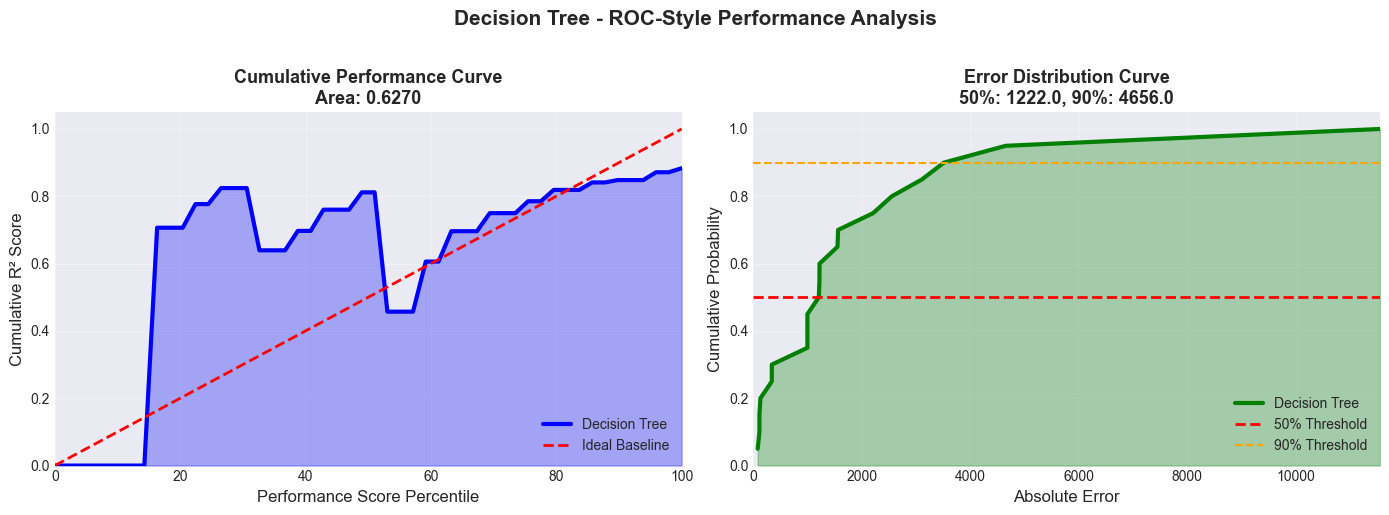


Generating curve for Random Forest...


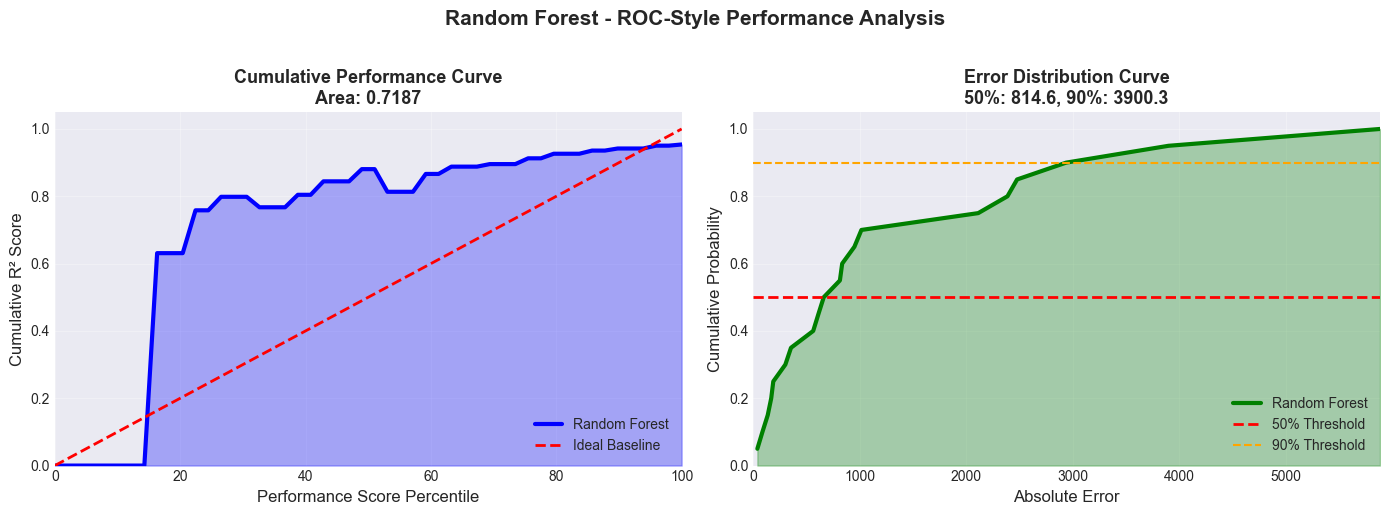


Generating curve for XGBoost...


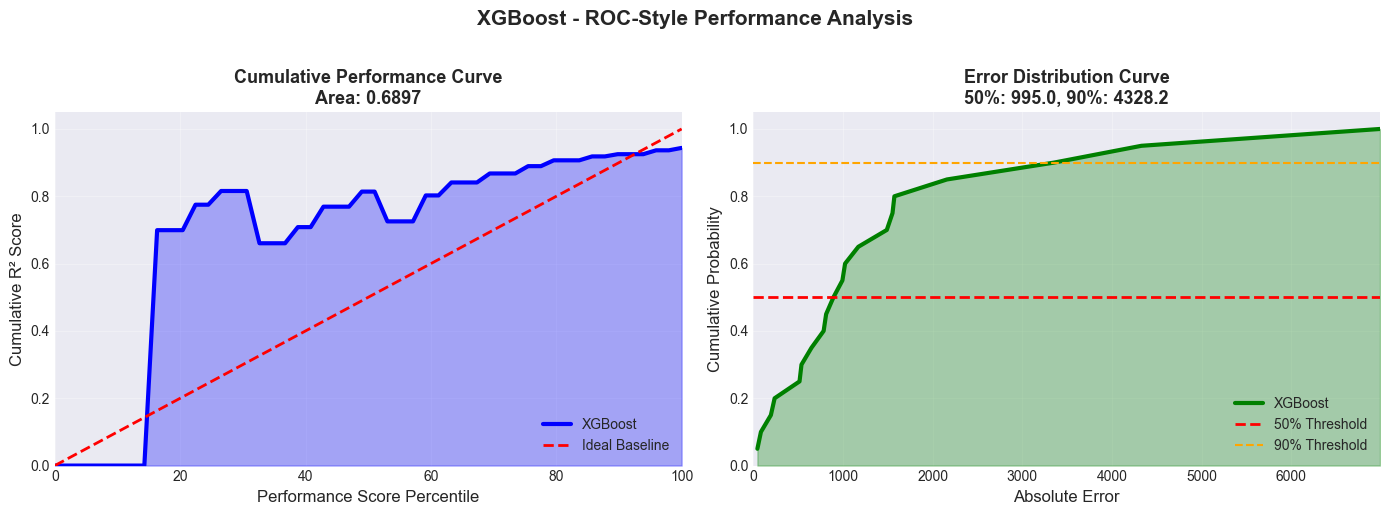


Generating curve for LightGBM...


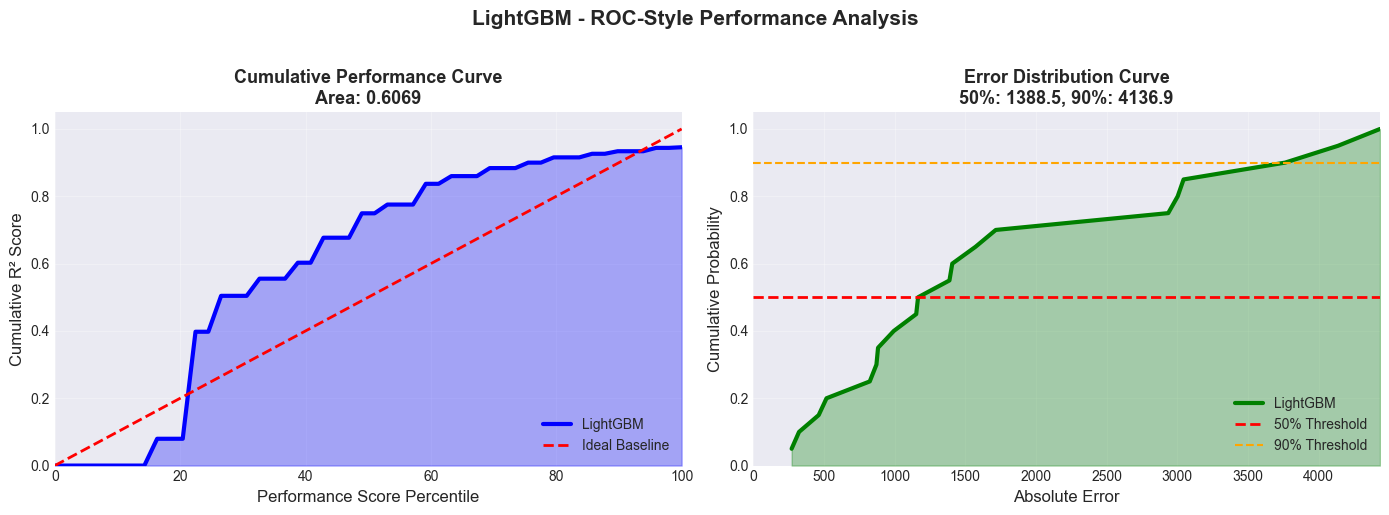


All ROC-style curves generated successfully!


In [120]:
# Individual ROC-Style Curves for Each Model
print("\n" + "="*70)
print("GENERATING INDIVIDUAL ROC-STYLE CURVES FOR EACH MODEL")
print("="*70)

for model_name, metrics in results.items():
    print(f"\nGenerating curve for {model_name}...")
    
    # Get predictions
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: Cumulative Performance Curve
    percentiles = np.linspace(0, 100, 50)
    cumulative_r2 = []
    
    for p in percentiles:
        threshold = np.percentile(y_test, p)
        mask = y_test <= threshold
        if mask.sum() > 1:
            r2 = r2_score(y_test[mask], model.predict(X_test_scaled)[mask])
            cumulative_r2.append(max(r2, 0))
        else:
            cumulative_r2.append(0)
    
    ax1.plot(percentiles, cumulative_r2, 'b-', linewidth=3, label=f'{model_name}')
    ax1.plot([0, 100], [0, 1], 'r--', linewidth=2, label='Ideal Baseline')
    ax1.fill_between(percentiles, cumulative_r2, alpha=0.3, color='blue')
    
    auc_metric = np.trapz(cumulative_r2, percentiles) / 100
    
    ax1.set_xlabel('Performance Score Percentile', fontsize=12)
    ax1.set_ylabel('Cumulative R² Score', fontsize=12)
    ax1.set_title(f'Cumulative Performance Curve\nArea: {auc_metric:.4f}', fontsize=13, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 1.05])
    
    # Right plot: Error Magnitude Distribution (ROC-style)
    errors = np.abs(y_test - y_pred)
    sorted_errors = np.sort(errors)
    cumulative_prob = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    
    ax2.plot(sorted_errors, cumulative_prob, 'g-', linewidth=3, label=f'{model_name}')
    ax2.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='50% Threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', linewidth=1.5, label='90% Threshold')
    ax2.fill_between(sorted_errors, cumulative_prob, alpha=0.3, color='green')
    
    # Find error at 50% and 90%
    error_50 = sorted_errors[int(0.5 * len(sorted_errors))]
    error_90 = sorted_errors[int(0.9 * len(sorted_errors))]
    
    ax2.set_xlabel('Absolute Error', fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontsize=12)
    ax2.set_title(f'Error Distribution Curve\n50%: {error_50:.1f}, 90%: {error_90:.1f}', fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, max(sorted_errors)])
    ax2.set_ylim([0, 1.05])
    
    plt.suptitle(f'{model_name} - ROC-Style Performance Analysis', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("All ROC-style curves generated successfully!")
print("="*70)

In [121]:
# Final Project Summary
print("\n" + "="*70)
print("CPU PERFORMANCE PREDICTION - PROJECT COMPLETED!")
print("="*70)

print("\nDATASET SUMMARY:")
print(f"   - Total CPUs: {len(df)}")
print(f"   - Total Features: {len(df.columns)}")
print(f"   - Intel CPUs: {len(df[df['Brand']=='Intel'])}")
print(f"   - AMD CPUs: {len(df[df['Brand']=='AMD'])}")
print(f"   - Desktop CPUs: {len(df[df['Type']=='Desktop'])}")
print(f"   - Laptop CPUs: {len(df[df['Type']=='Laptop'])}")
print(f"   - Year Range: {df['Year'].min()} - {df['Year'].max()}")

print("\nMODELS TRAINED:")
for i, (name, metrics) in enumerate(results.items(), 1):
    print(f"   {i}. {name}")

print(f"\nBEST MODEL: {best_model_name}")
print(f"   - R2 Score: {results[best_model_name]['R2']:.4f}")
print(f"   - RMSE: {results[best_model_name]['RMSE']:.2f}")
print(f"   - MAE: {results[best_model_name]['MAE']:.2f}")
print(f"   - MAPE: {results[best_model_name]['MAPE']:.2f}%")

print("\nSAVED ARTIFACTS:")
print(f"   - Best Model: {model_filename}")
print(f"   - Scaler: {scaler_filename}")
print(f"   - Encoders: {encoders_filename}")
print(f"   - Features: {feature_names_filename}")


CPU PERFORMANCE PREDICTION - PROJECT COMPLETED!

DATASET SUMMARY:
   - Total CPUs: 96
   - Total Features: 43
   - Intel CPUs: 55
   - AMD CPUs: 41
   - Desktop CPUs: 59
   - Laptop CPUs: 37
   - Year Range: 2022 - 2024

MODELS TRAINED:
   1. Linear Regression
   2. Decision Tree
   3. Random Forest
   4. XGBoost
   5. LightGBM

BEST MODEL: Random Forest
   - R2 Score: 0.9539
   - RMSE: 1994.52
   - MAE: 1322.27
   - MAPE: 4.35%

SAVED ARTIFACTS:
   - Best Model: models/best_model_Random_Forest_20251202_203437.joblib
   - Scaler: models/scaler_20251202_203437.joblib
   - Encoders: models/label_encoders_20251202_203437.pkl
   - Features: models/feature_names_20251202_203437.pkl
